In [1]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt
import random

cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

if 'aigents_api' in sys.modules:
    del sys.modules['aigents_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from pygents.learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from pygents.aigents_api import TextMetrics
from pygents.plot import plot_dict
from pygents.util import dictcount

model_family = 'multiclass_view_cleaned'
if not os.path.exists('data/models/distortions/multiclass_task/overfitting_kaggle_multiclass/'+model_family+'/'):
    os.makedirs('data/models/distortions/multiclass_task/overfitting_kaggle_multiclass/'+model_family+'/')

grand_t0 = dt.datetime.now()

def language_metrics(metrics_list):
    metrics = {}
    for m in metrics_list:
        metrics[m] = 'data/models/distortions/multiclass_task/overfitting_kaggle_multiclass/'+model_family+'/' + m + '.txt'
    return metrics


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kzvau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 

#df = df3[0:5] # hack for test!

df

Patient Question  \
0     Hello, I have a beautiful,smart,outgoing and a...   
1     Since I was about 16 years old I’ve had these ...   
2      So I’ve been dating on and off this guy for a...   
3     My parents got divorced in 2004. My mother has...   
4     I don’t really know how to explain the situati...   
...                                                 ...   
2525  I’m a 21 year old female. I spent most of my l...   
2526  I am 21 female and have not had any friends fo...   
2527  From the U.S.: My brother is 19 years old and ...   
2528  From the U.S.: I am a 21 year old woman who ha...   
2529  I recently moved out on my ex-roommate because...   

                                         Distorted part Dominant Distortion  \
0     The voice are always fimilar (someone she know...     Personalization   
1     I feel trapped inside my disgusting self and l...            Labeling   
2                                                   NaN       No Distortion   
3                                                   NaN       No Distortion   
4     I refused to go because I didn’t know if it wa...     Fortune-telling   
...                                                 ...                 ...   
2525                                                NaN       No Distortion   
2526  Now I am at university my peers around me all ...  Overgeneralization   
2527  He claims he’s severely depressed and has outb...       Mental filter   
2528                                                NaN       No Distortion   
2529                                                NaN       No Distortion   

     Secondary Distortion (Optional)  
0                                NaN  
1                Emotional Reasoning  
2                                NaN  
3                                NaN  
4                Emotional Reasoning  
...                              ...  
2525                             NaN  
2526                             NaN  
2527                    Mind Reading  
2528                             NaN  
2529                             NaN  

[2530 rows x 4 columns]

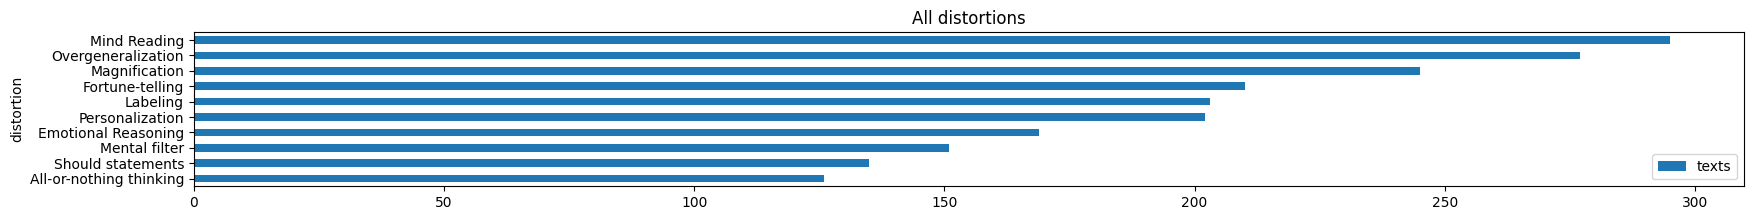

In [3]:
dists = {}
for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion)
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion)
        for d in ground_distortions:
            dictcount(dists,d)
        
plot_dict(
    dists,
    labels="distortion",
    values="texts",
    title="All distortions",
    head=20
)

# Create learning functions
### Functions for including key N-grams and creating model files

In [4]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram

def create_model_files(filtered_model_ngram):
    # Create .txt files for each distortion
    output_dir = "data/models/distortions/multiclass_task/overfitting_kaggle_multiclass/"+model_family
    distortion_file_path = f"{output_dir}/Distortion.txt"
    distortions_labels = []

    with open(distortion_file_path, "w", encoding="utf-8") as distortion_file:
        for distortion, ngrams in filtered_model_ngram.items():
            distortion_ = distortion.replace(" ", "_")
            file_path = f"{output_dir}/{distortion_}.txt"
            sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True)
            distortions_labels.append(distortion_)
            with open(file_path, "w", encoding="utf-8") as f:
                for ngram, metric_value in sorted_ngrams:
                    ngram_str = ' '.join(ngram)
                    f.write(f"{ngram_str}\t{metric_value}\n")
                    if distortion != "No Distortion":
                            distortion_file.write(f"{ngram_str}\t{metric_value}\n")

    return (list(set(distortions_labels) - {'No_Distortion'}))

### Evaluate functions

In [5]:
all_metrics = ['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Labeling',
          'Mind_Reading','Personalization','Emotional_Reasoning','Magnification','Should_statements']

def our_evaluator_test(expected_distortions,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True if (m in expected_distortions) else False
    return dic

def our_evaluator_tm(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    dic = {}
    for m in all_metrics:
        dic[m] = True if m in metrics and metrics[m] > threshold else False
    return dic

def our_evaluator_true(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True
    return dic
    
def our_evaluator_false(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = False
    return dic

def our_evaluator_random(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = random.choice([True, False])
    return dic

def dictval(dic,key,val):
    return dic[key] if key in dic else val 

def pre_rec_f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return precision, recall, 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_tm_df(df,tm,evaluator,threshold,debug=False):
    true_positives = {}
    true_negatives = {}
    false_positives = {}
    false_negatives = {}
    pre = {}
    rec = {}
    f1 = {}
    acc = {}
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion.replace(' ','_'))
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion.replace(' ','_'))

        if evaluator == our_evaluator_test:
            distortions_by_metric = evaluator(ground_distortions,text,threshold) #hack to test metrics
        else:
            distortions_by_metric = evaluator(tm,text,threshold)

        if debug:
            print(ground_distortions,'=>',[m for m in distortions_by_metric if distortions_by_metric[m]])
        
        for metric in distortions_by_metric:
            our_distortion = distortions_by_metric[metric]
            if (metric in ground_distortions) and our_distortion == True:
                dictcount(true_positives,metric)
            if (not metric in ground_distortions) and our_distortion == True:
                dictcount(false_positives,metric)
            if (not metric in ground_distortions) and our_distortion == False:
                dictcount(true_negatives,metric)
            if (metric in ground_distortions) and our_distortion == False:
                dictcount(false_negatives,metric)

    if debug:
        #print()
        print('TP:',true_positives)
        print('FP:',false_positives)
        print('TN:',true_negatives)
        print('FN:',false_negatives)
    
    for metric in all_metrics:
        precision, recall, f1score = pre_rec_f1_from_counts(dictval(true_positives,metric,0), dictval(true_negatives,metric,0), 
                                   dictval(false_positives,metric,0), dictval(false_negatives,metric,0))
        pre[metric] = precision
        rec[metric] = recall
        f1[metric] = f1score
        acc[metric] = (dictval(true_positives,metric,0) + dictval(true_negatives,metric,0)) / len(df)
    
    return pre, rec, f1, acc


### Function for analyzing the dataset

In [7]:
def analyse_dataset(ngram_max, df, print_or_plot, ngram_selection_metric = None, ngram_inclusion_threshold = None):
    
    tfidf = count_ngrams_plus_tf_idf(df,ngram_max,binary=False, clean_punct=True)
    
    distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
    norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
    norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df,ngram_max,binary=False, clean_punct=True)
        
    selection_metrics = {
        'TF-IDF': tfidf,
        'F':frequency,
        'UF':unique_frequency,
        'FN':frequency_self_normalized,
        'UFN':unique_frequency_self_normalized,
        'UFN/D/D':norm_uniq_n_gram_dicts,
        'FN*UFN':norm_norm_uniq,
        'FN*UFN/D':norm_norm_uniq_norm,
        'CFR':cfr,
        'FCR':fcr,
        'MR':mr,
        'NLMI':nl_mi}
    
    ngram_inclusion_thresholds = [ngram_inclusion_threshold] if ngram_inclusion_threshold is not None else [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
    ngram_selection_metric = [ngram_selection_metric] if ngram_selection_metric is not None else list(selection_metrics.keys())
    
    for inclusion_threshold in ngram_inclusion_thresholds:
        for selection_metric in ngram_selection_metric:
            model_ngram = selection_metrics[selection_metric]
            
            # Filter out values below the threshold
            filtered_model_ngram = ngrams_inclusion(model_ngram, inclusion_threshold)

            # Create .txt files for each distortion
            distortions_labels = create_model_files(filtered_model_ngram)
            tm = TextMetrics(language_metrics(distortions_labels), encoding = "utf-8", debug=False)

            if print_or_plot == 'print_results':
                print('\nN-gram selection metric:', selection_metric)
                print('N-gram max length:', ngram_max)
                print('N-gram inclusion threshold:', inclusion_threshold)
    
            pres = [[] for i in range(len(all_metrics))]
            recs = [[] for i in range(len(all_metrics))]
            f1s = [[] for i in range(len(all_metrics))]
            accs = [[] for i in range(len(all_metrics))]
            
            for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
                pre, rec, f1, acc = evaluate_tm_df(df,tm,our_evaluator_tm,threshold)
                mi = 0
                if print_or_plot == 'print_results':
                    print('\tThreshold:', threshold, '(distortion, precision, recall, F1 score, accuracy):')
                for metric in all_metrics:
                    pres[mi].append(pre[metric])
                    recs[mi].append(rec[metric])
                    f1s[mi].append(f1[metric])
                    accs[mi].append(acc[metric])
                    mi += 1
                    if print_or_plot == 'print_results':
                        # print('\t\t', metric, pre[metric], rec[metric], f1[metric], acc[metric], sep='\t')
                        print('\t\t\t', metric, f1[metric], sep='\t')
    
    return f1s

# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [8]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','CFR','FCR','MR','NLMI']
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]

for ngram_max in ngram_max_values:
    f1s = analyse_dataset(ngram_max, df, 'print_results')


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	Threshold: 0.1 (distortion, precision, recall, F1 score, accuracy):
				All-or-nothing_thinking	0.10979228486646884
				Fortune-telling	0.32710280373831774
				Mental_filter	0.13161659513590843
				Overgeneralization	0.16361556064073227
				Labeling	0.15549597855227884
				Mind_Reading	0.17796610169491528
				Personalization	0.192
				Emotional_Reasoning	0.22594142259414227
				Magnification	0.17352056168505514
				Should_statements	0.22641509433962265
	Threshold: 0.2 (distortion, precision, recall, F1 score, accuracy):
				All-or-nothing_thinking	0.11494252873563218
				Fortune-telling	0.37536656891495607
				Mental_filter	0.13528336380255943
				Overgeneralization	0.1839080459770115
				Labeling	0.1818181818181818
				Mind_Reading	0.19155844155844157
				Personalization	0.2073578595317726
				Emotional_Reasoning	0.25840707964601767
				Magnification	0.18988061398521885
				Should_statements	0.316353

### Our best model obtained through the optimal combination of hyper-parameters

In [9]:
# Best model
f1s = analyse_dataset(3, df, 'print_results', 'FN', 70)


N-gram selection metric: FN
N-gram max length: 3
N-gram inclusion threshold: 70
	Threshold: 0.1 (distortion, precision, recall, F1 score, accuracy):
				All-or-nothing_thinking	0.9960474308300395
				Fortune-telling	0.9767441860465117
				Mental_filter	0.993421052631579
				Overgeneralization	0.9963898916967509
				Labeling	0.9805825242718447
				Mind_Reading	0.984974958263773
				Personalization	0.9877149877149877
				Emotional_Reasoning	0.9940828402366864
				Magnification	0.9879032258064516
				Should_statements	0.9818181818181818
	Threshold: 0.2 (distortion, precision, recall, F1 score, accuracy):
				All-or-nothing_thinking	0.9960474308300395
				Fortune-telling	0.9836065573770492
				Mental_filter	0.9966996699669968
				Overgeneralization	0.9963898916967509
				Labeling	0.9926289926289927
				Mind_Reading	0.9932659932659933
				Personalization	0.9925925925925926
				Emotional_Reasoning	0.9940828402366864
				Magnification	0.98989898989899
				Should_statements	0.9854014598540146

# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

In [10]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def matrix_plot(row_labels, col_labels, matrix, absmax, title = None, vmin = None, vmax = None, dpi = None, titlefontsize = None, width = 20):
    plt.rcParams["figure.figsize"] = (width,len(row_labels)/4)
    if not dpi is None:
        plt.rcParams["figure.dpi"] = dpi
    p = sns.heatmap(matrix, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin = -absmax if vmin is None else vmin, 
                    vmax = absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        p.set_title(title,fontsize = titlefontsize)
    plt.show()


"""
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()
"""

'\ndef matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):\n    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)\n    if dpi is not None:\n        plt.rcParams["figure.dpi"] = dpi\n\n    fig, ax = plt.subplots()\n\n    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, \n                    vmin=-absmax if vmin is None else vmin, \n                    vmax=absmax if vmax is None else vmax, \n                    cmap=\'RdYlGn\', annot=True)\n    \n    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)\n\n    if title is not None:\n        if titlefontsize is None:\n            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))\n        ax.set_title(title, fontsize=titlefontsize, pad=20)\n\n    if subtitle is not None:\n        if subtitlefontsize is None:\n            subtitlefontsize = round(titlefontsize * 0.7)\

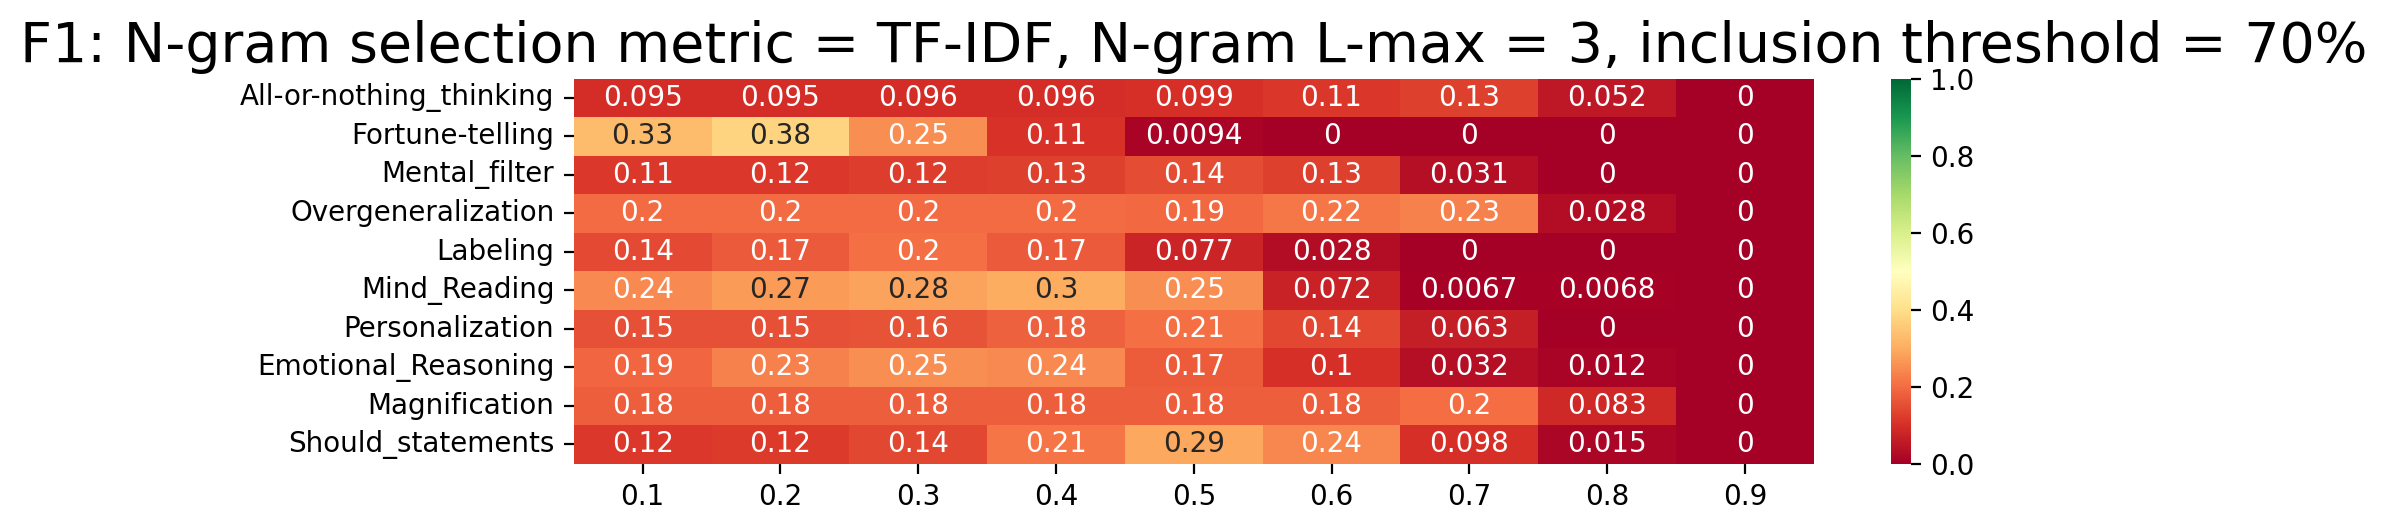

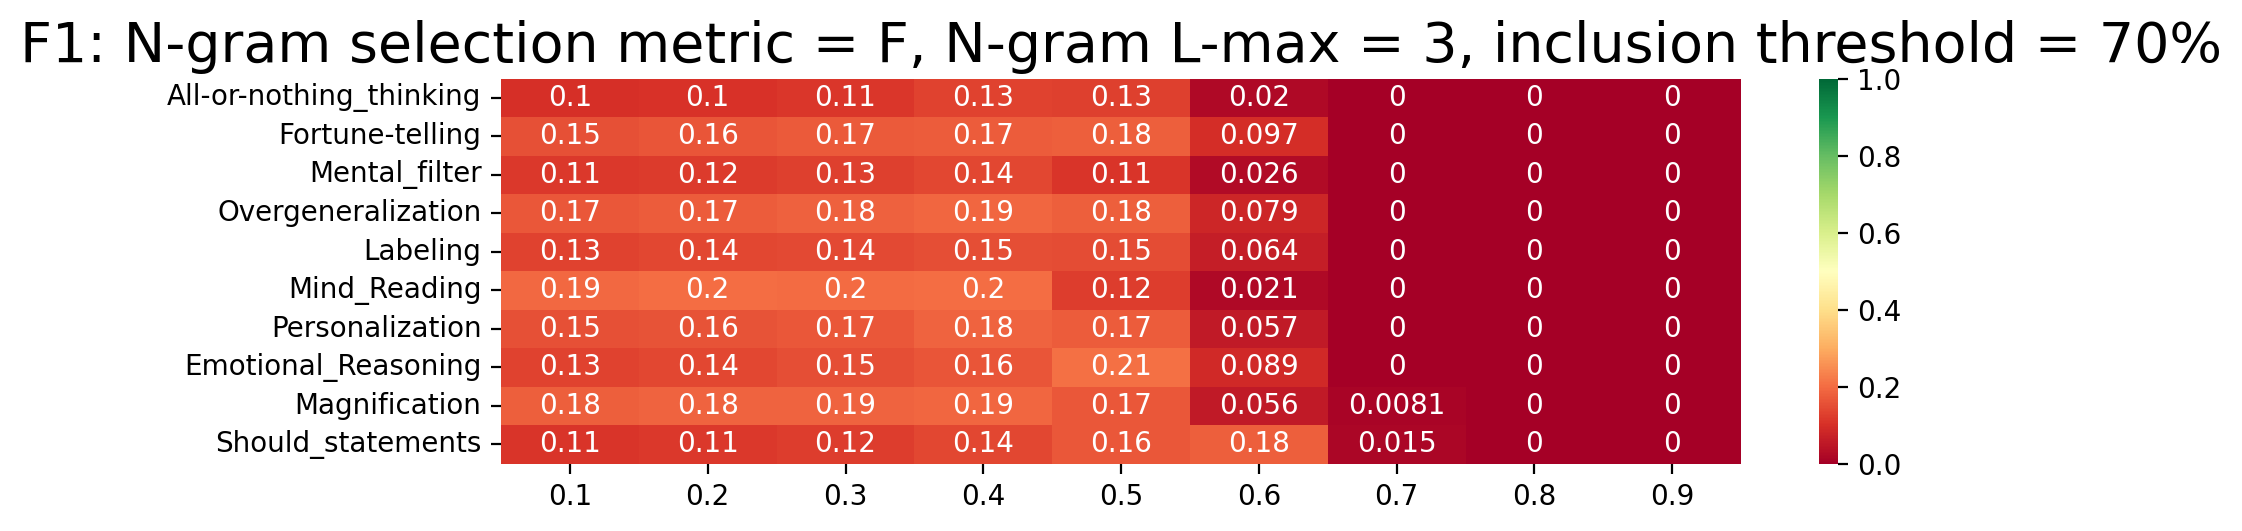

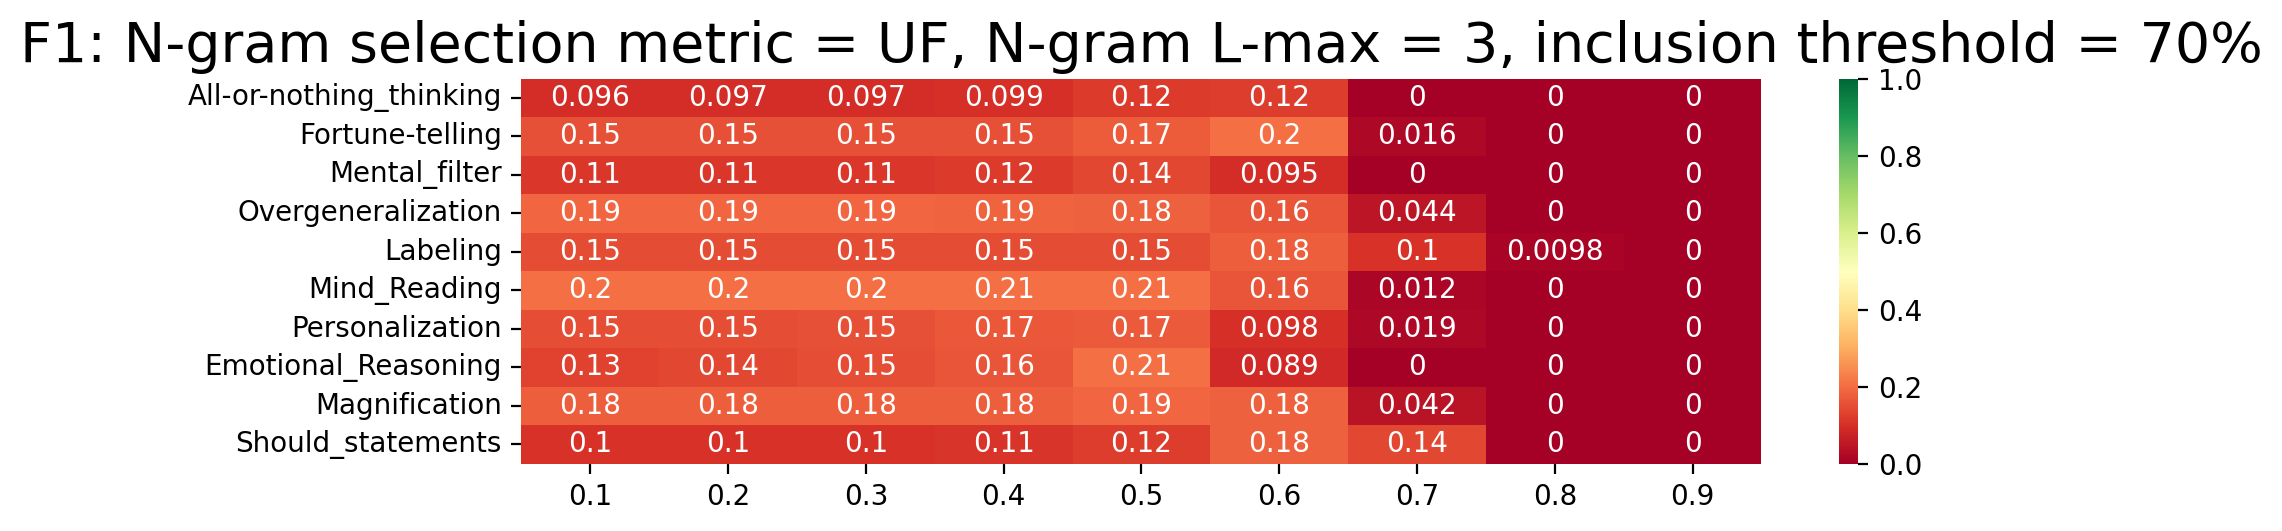

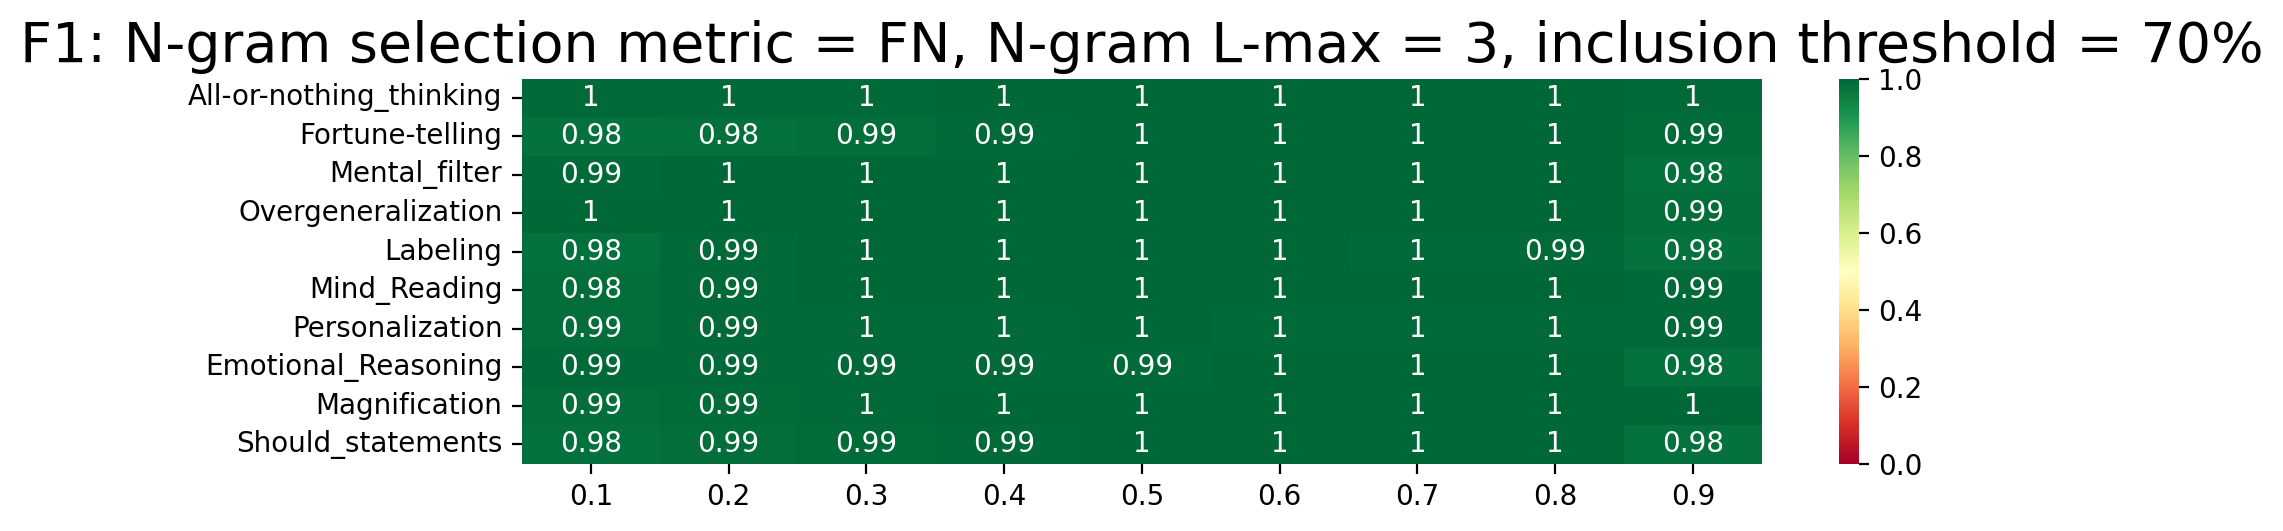

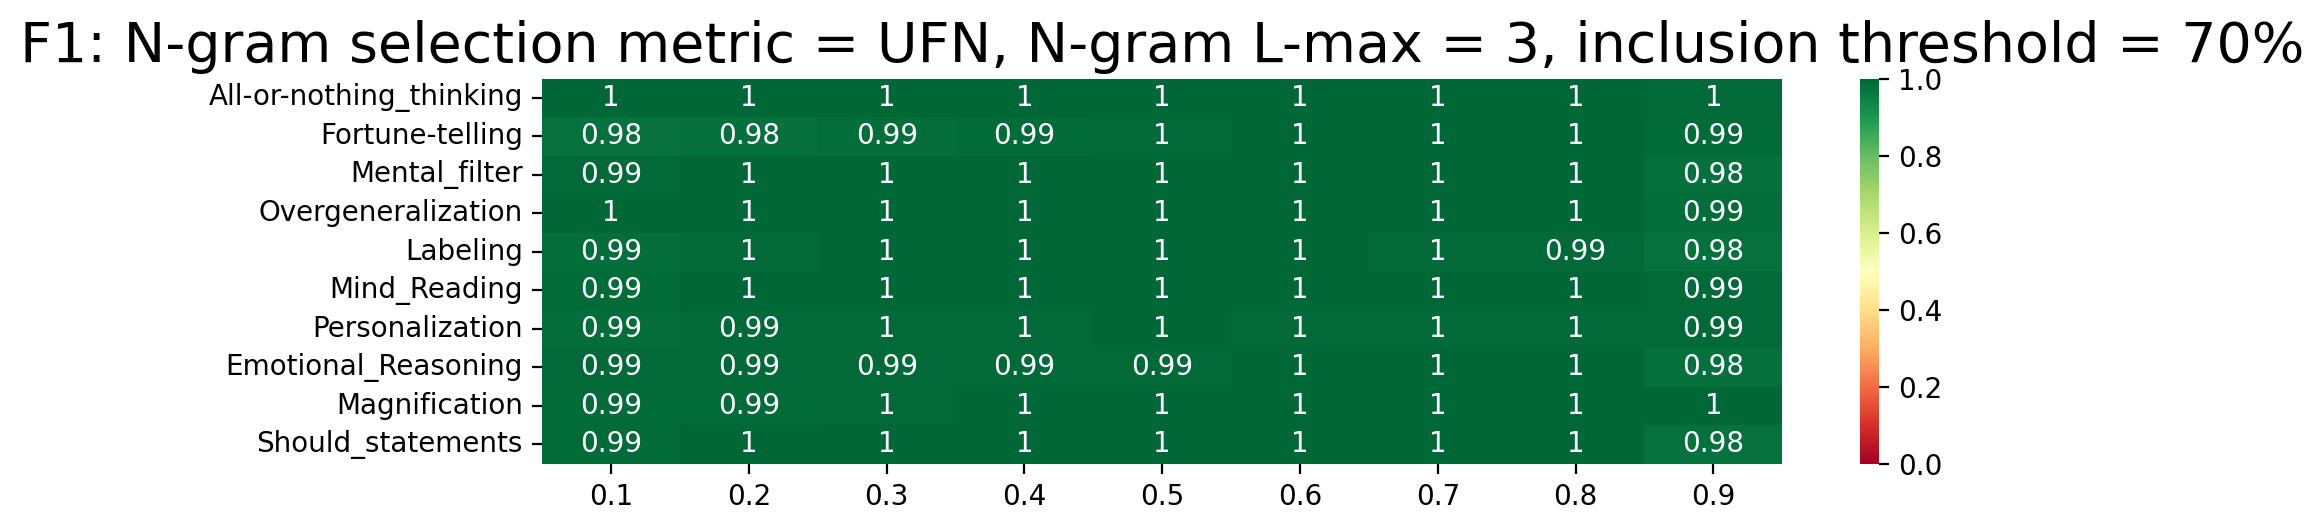

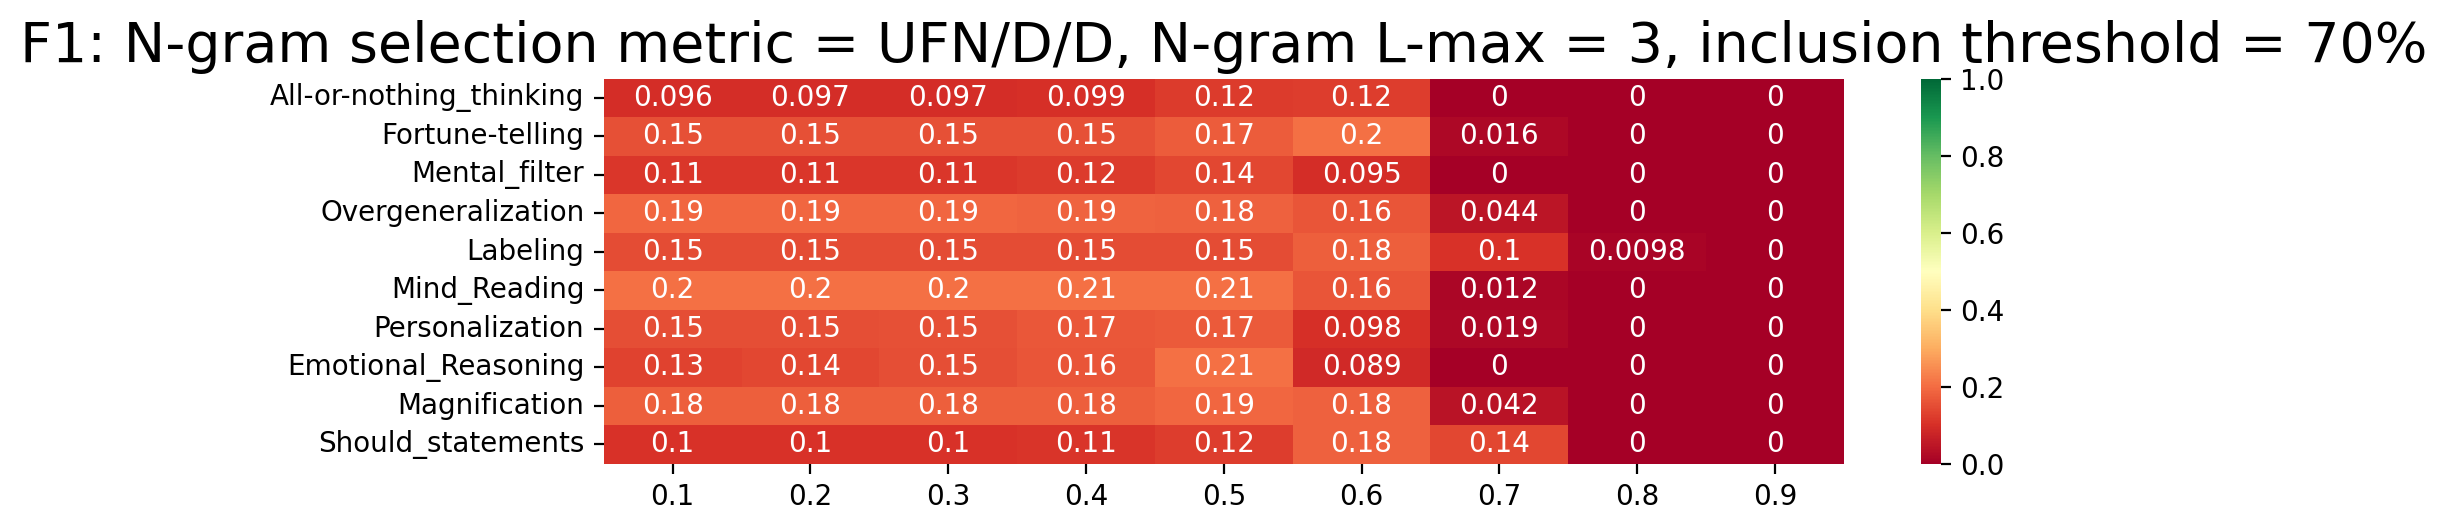

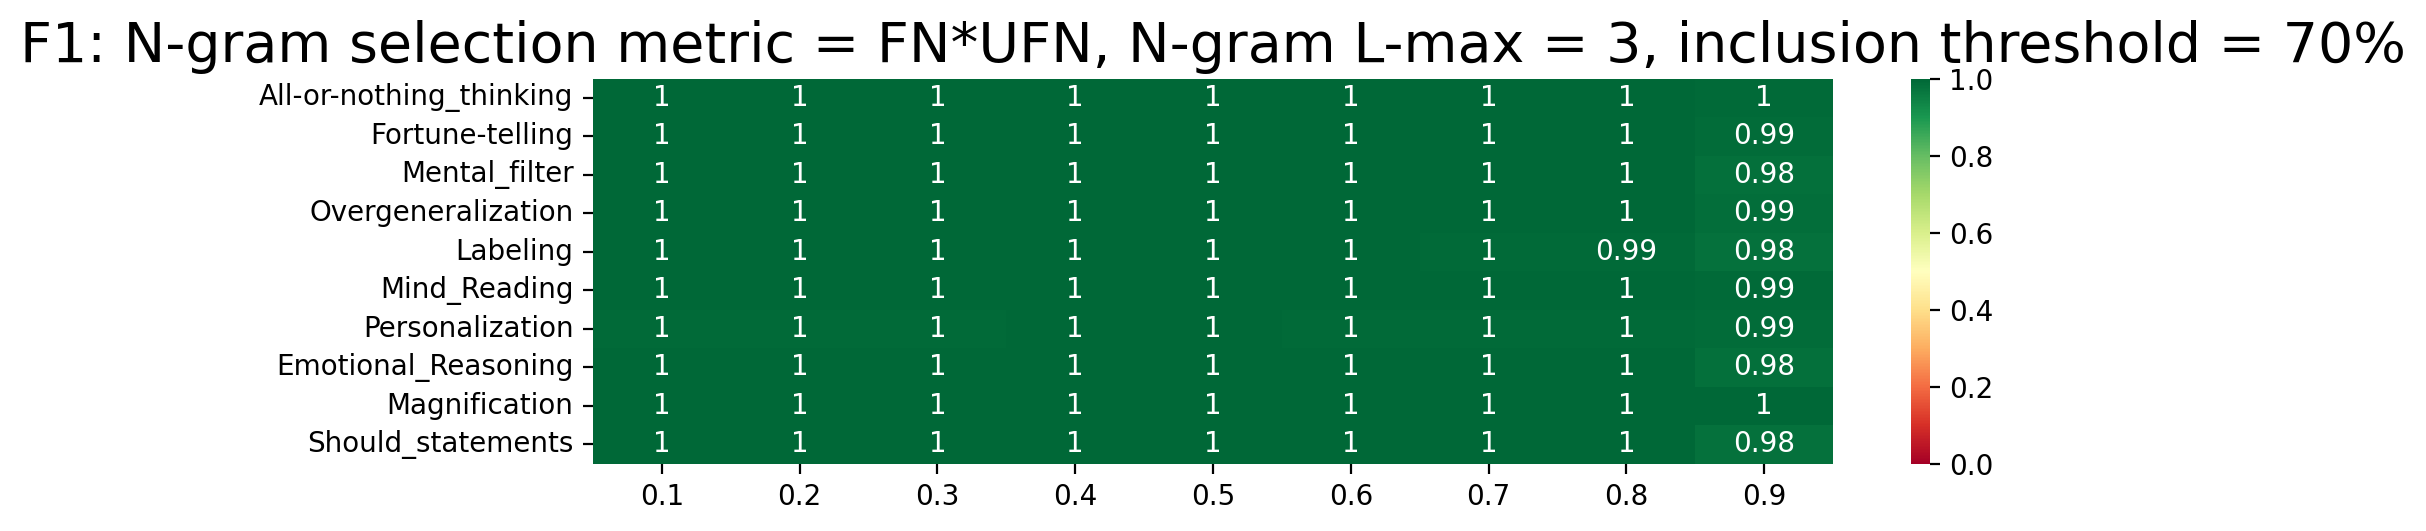

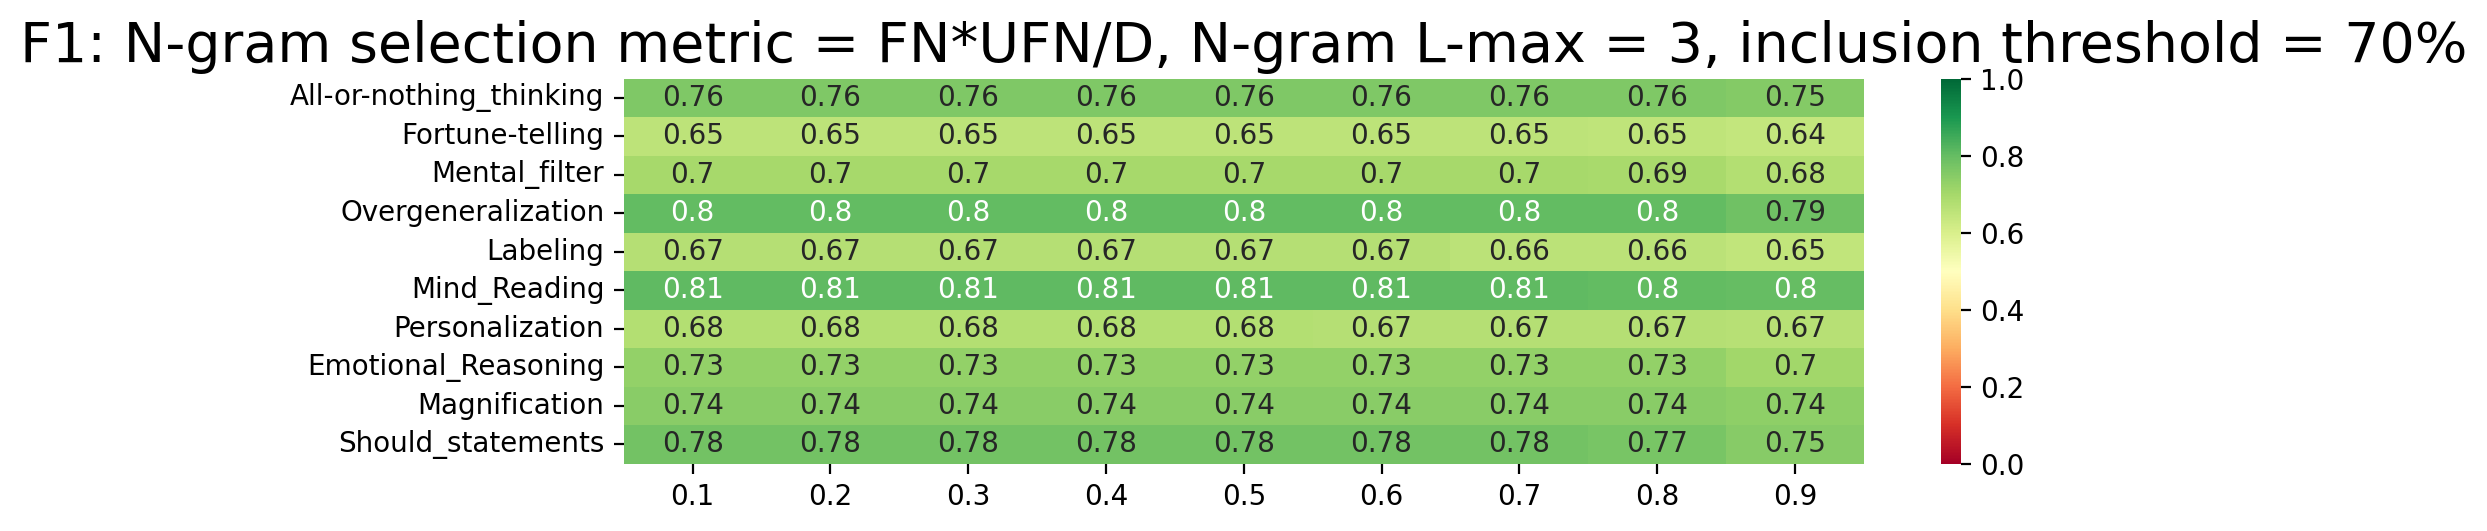

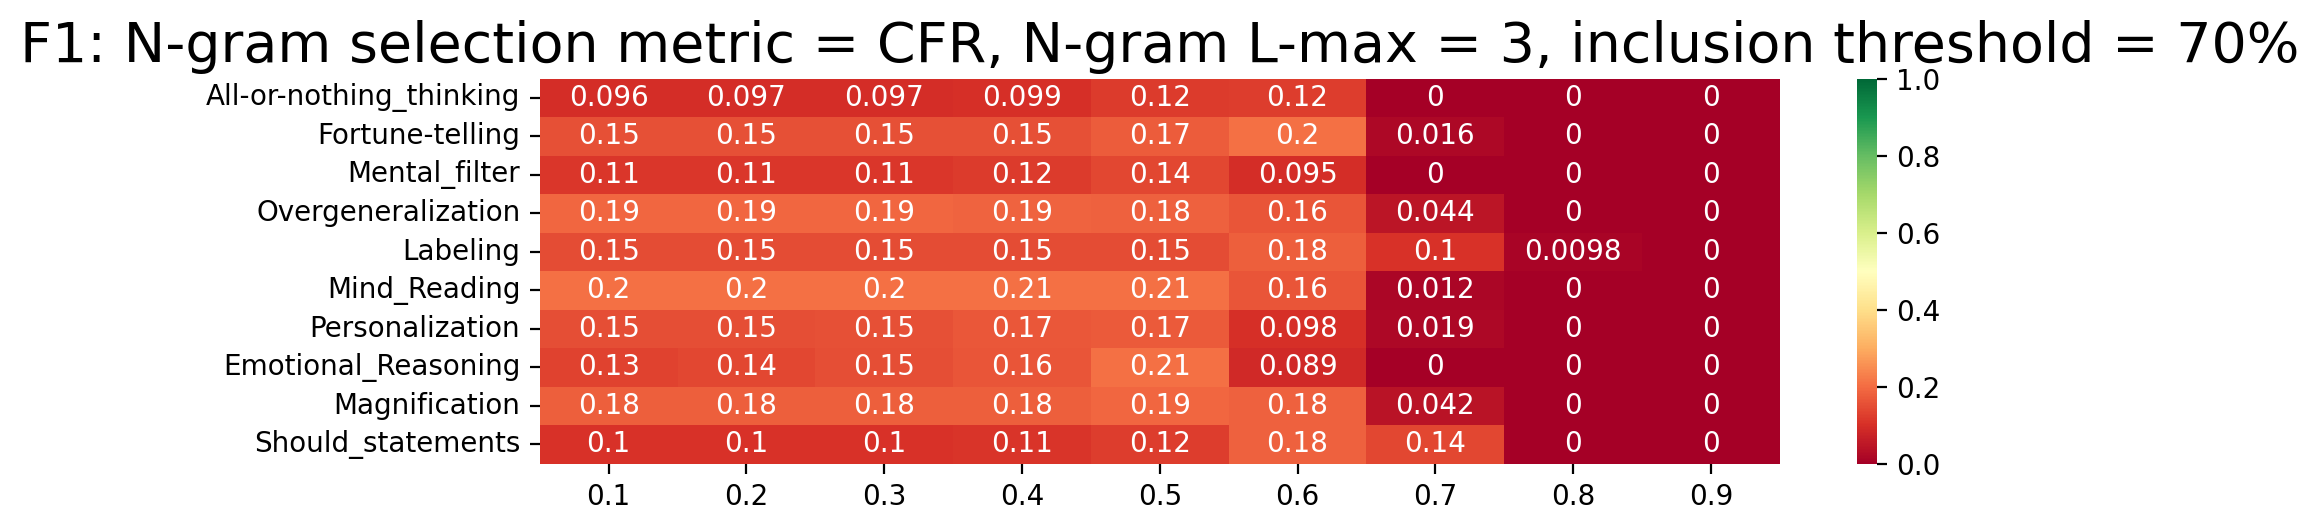

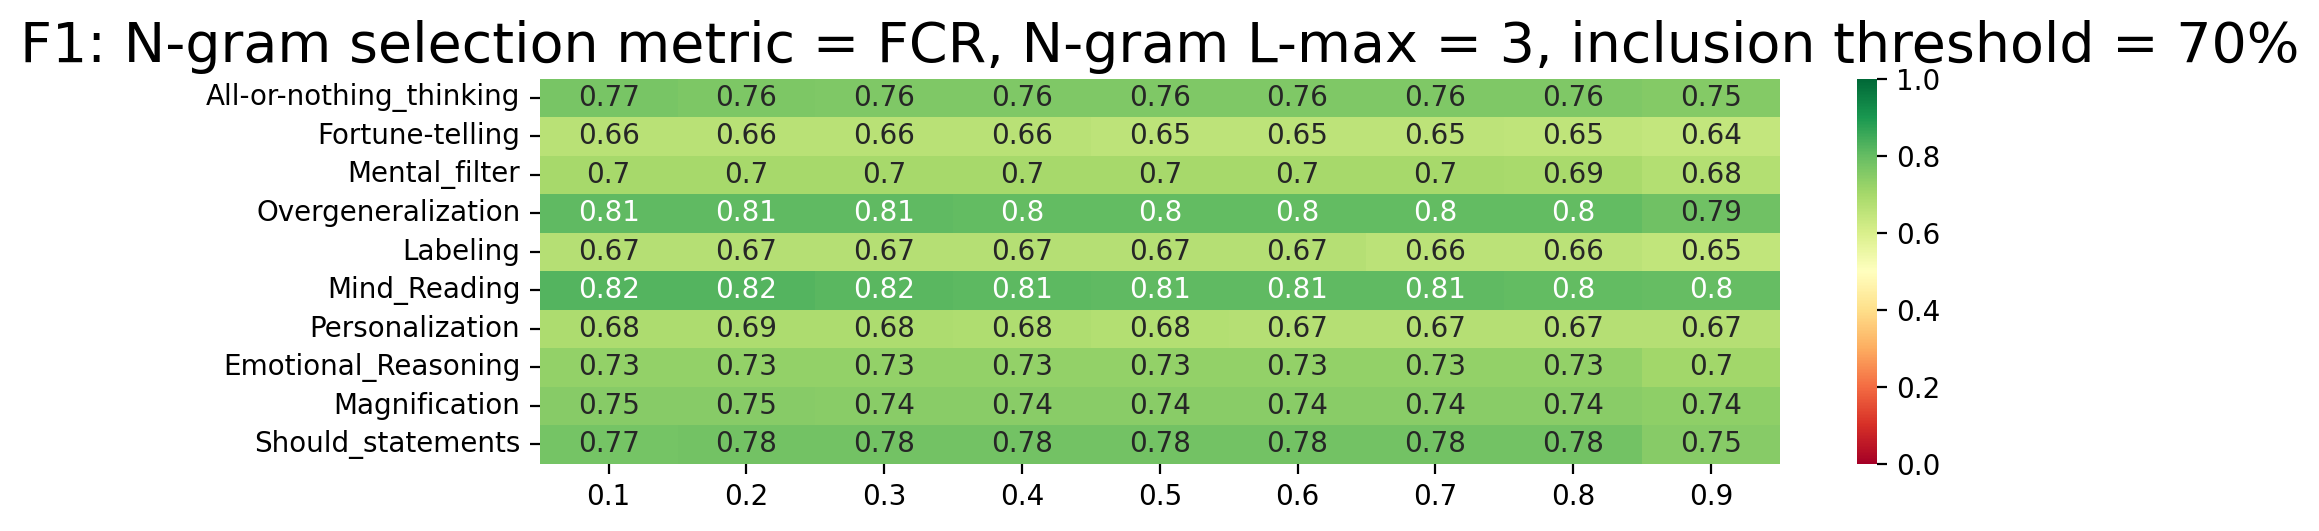

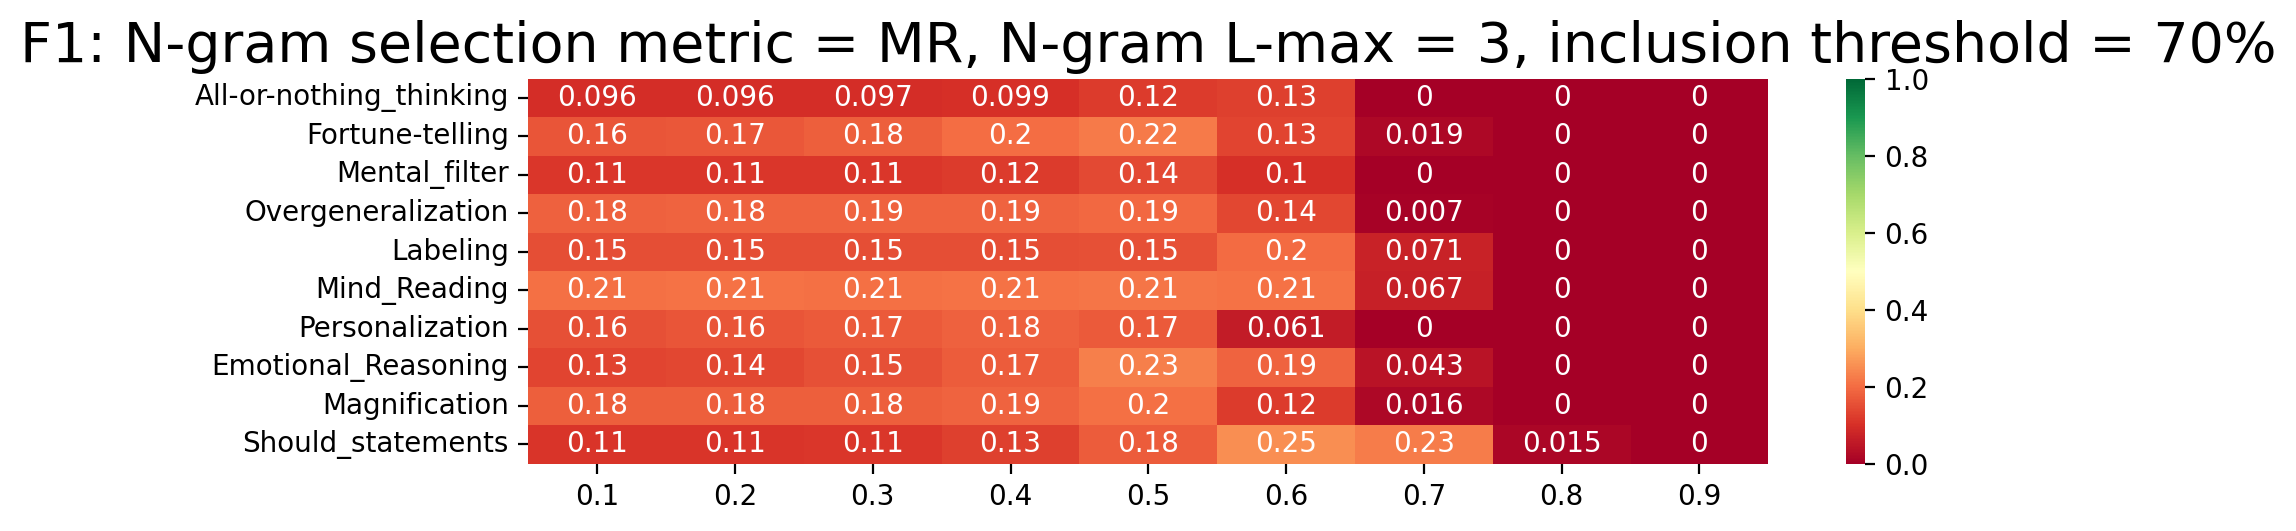

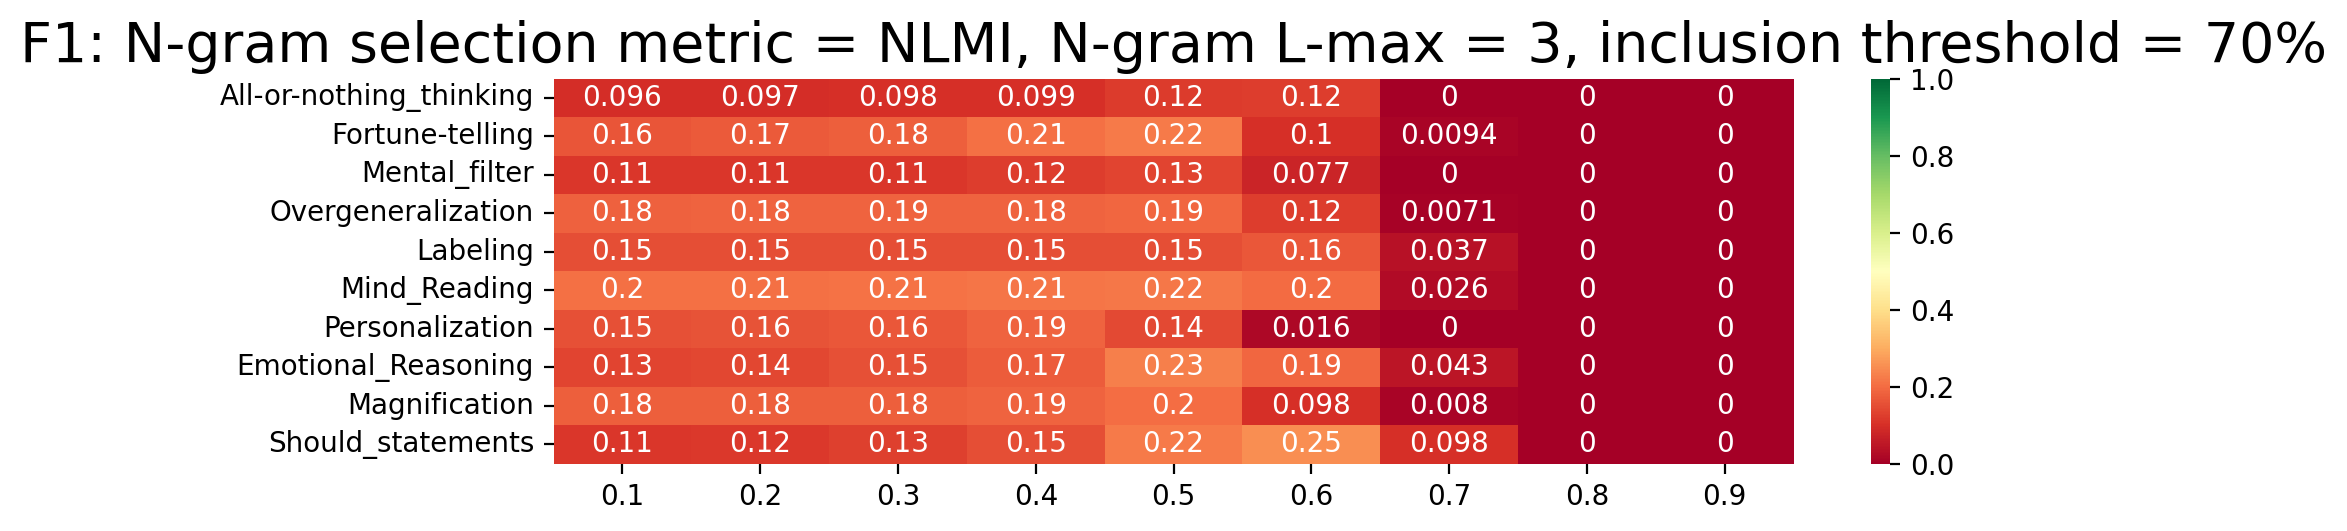

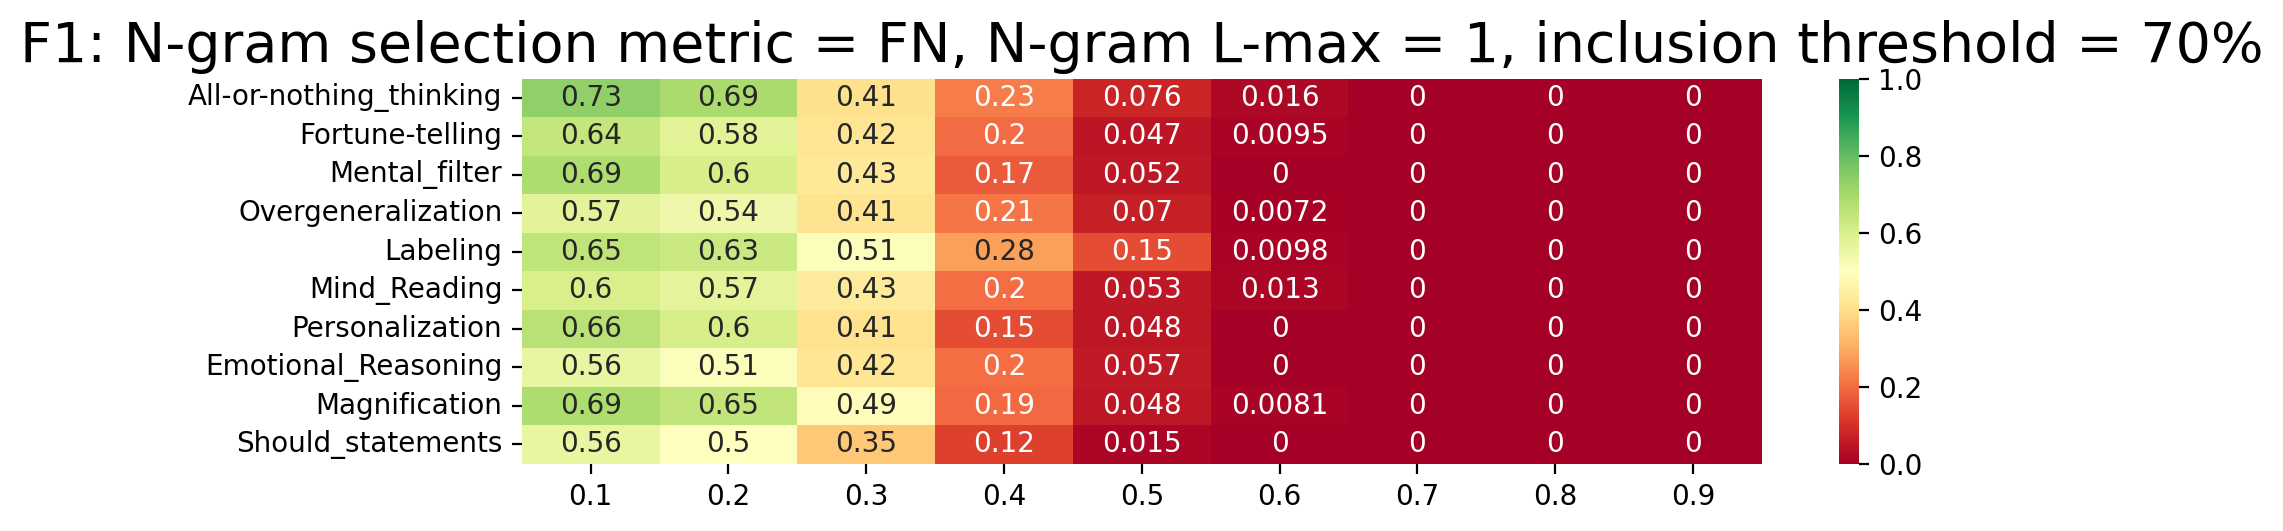

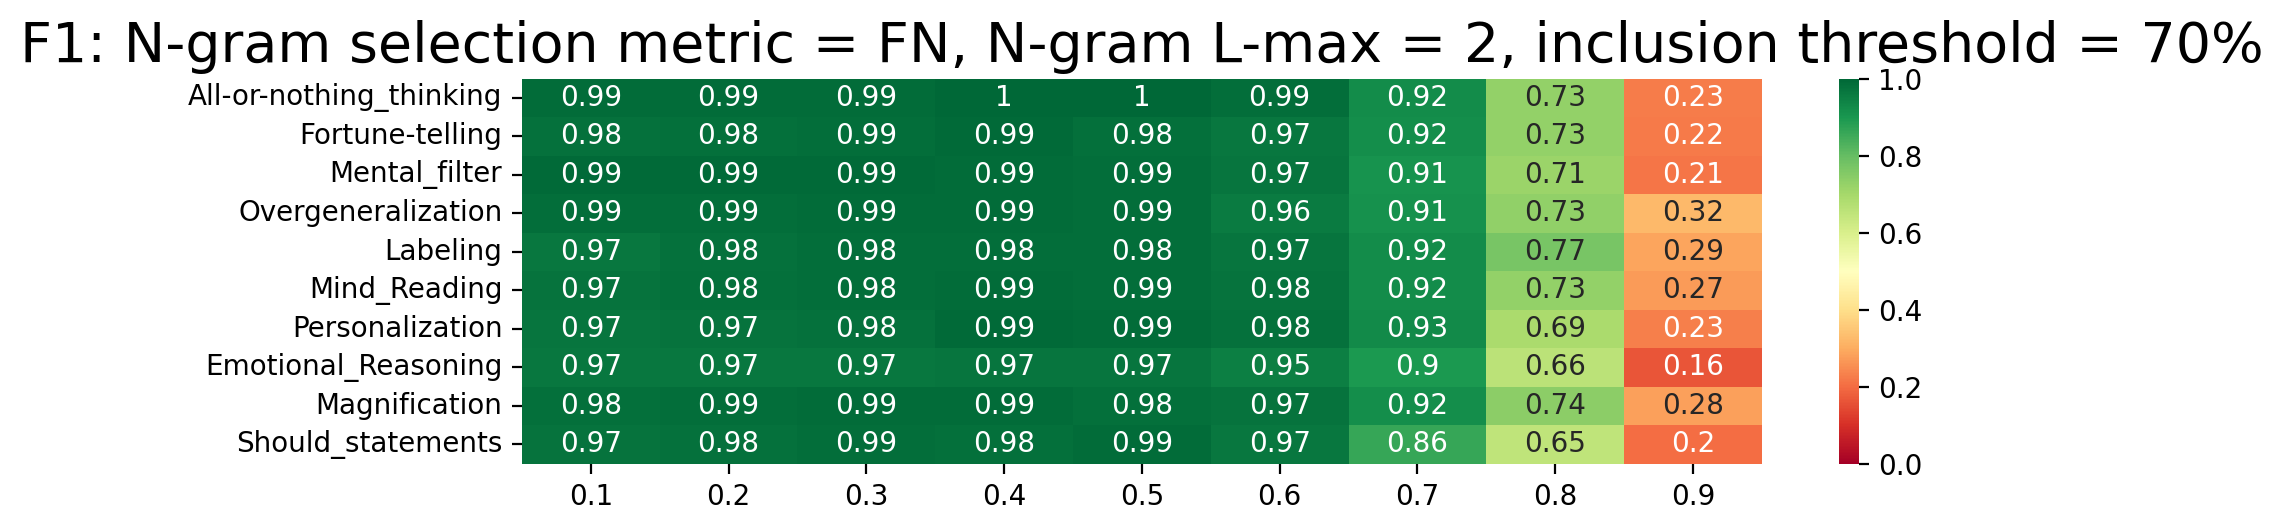

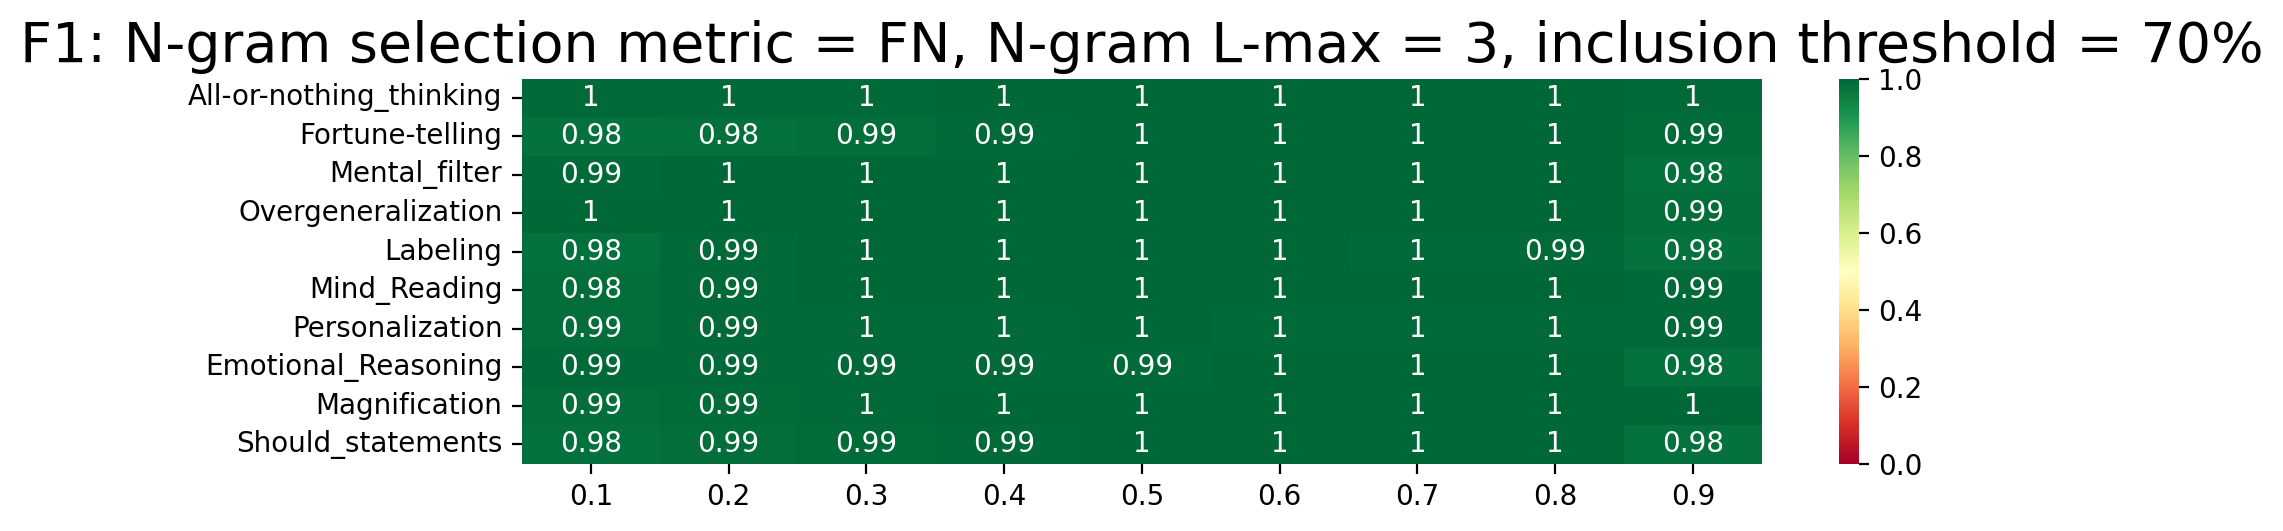

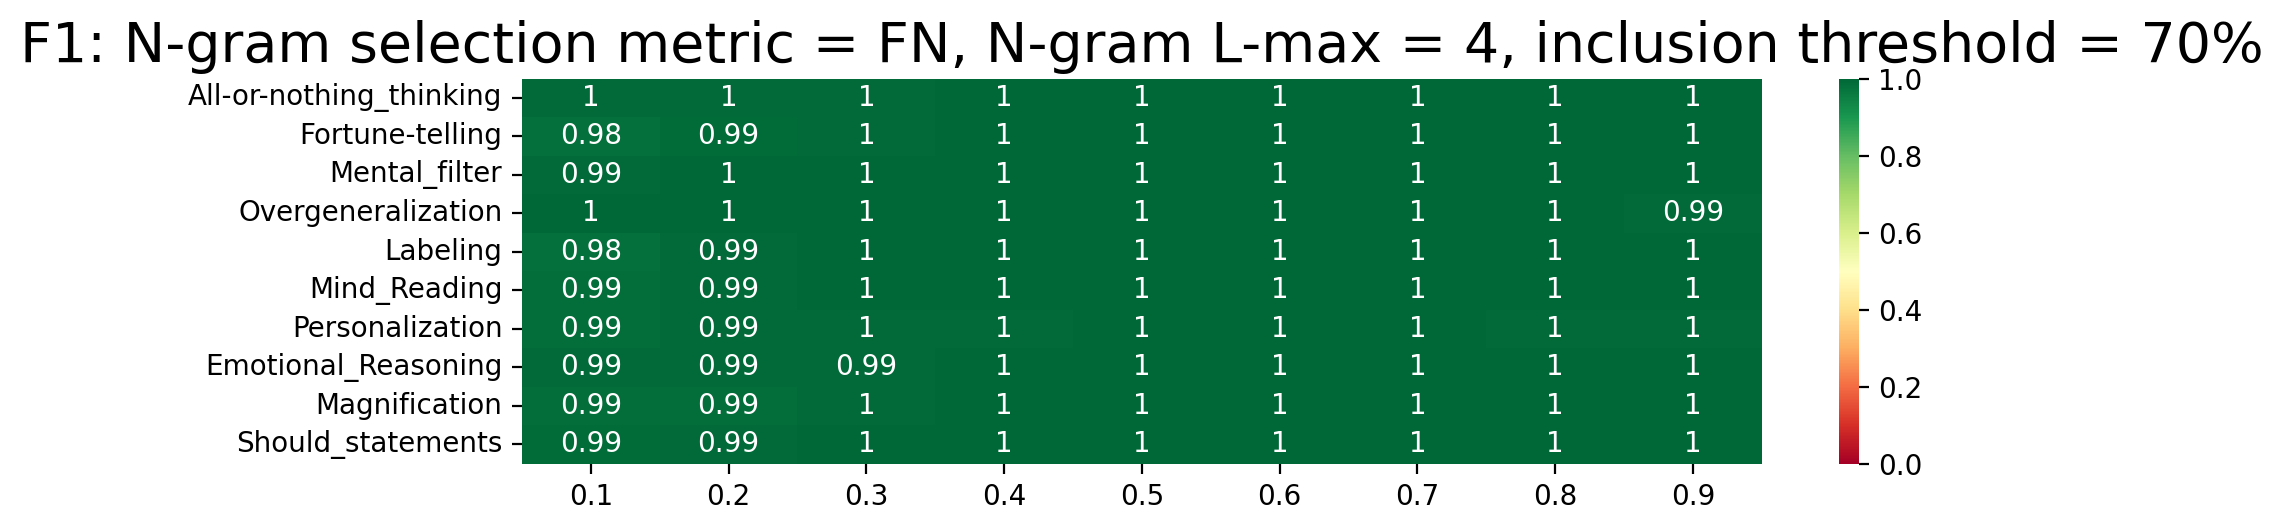

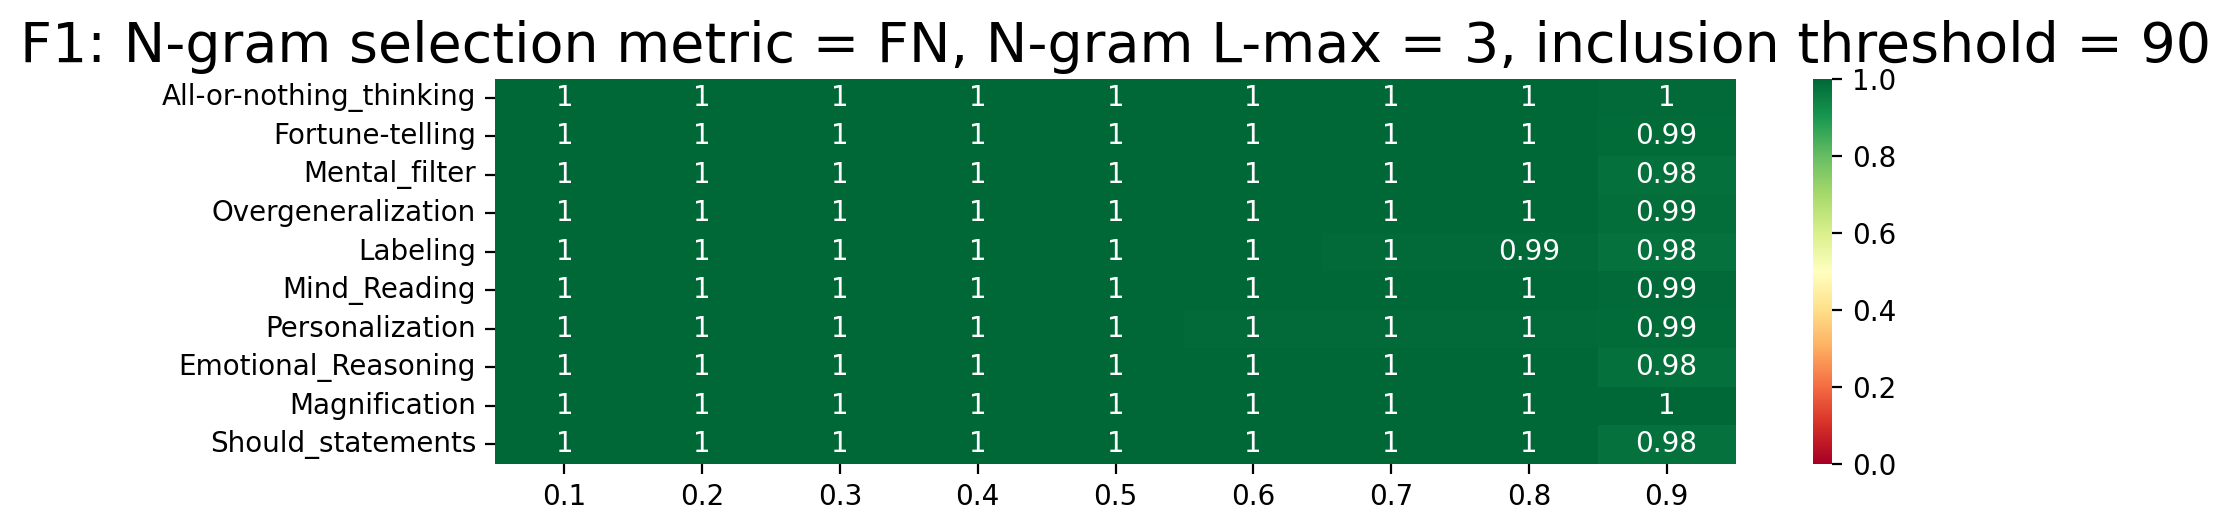

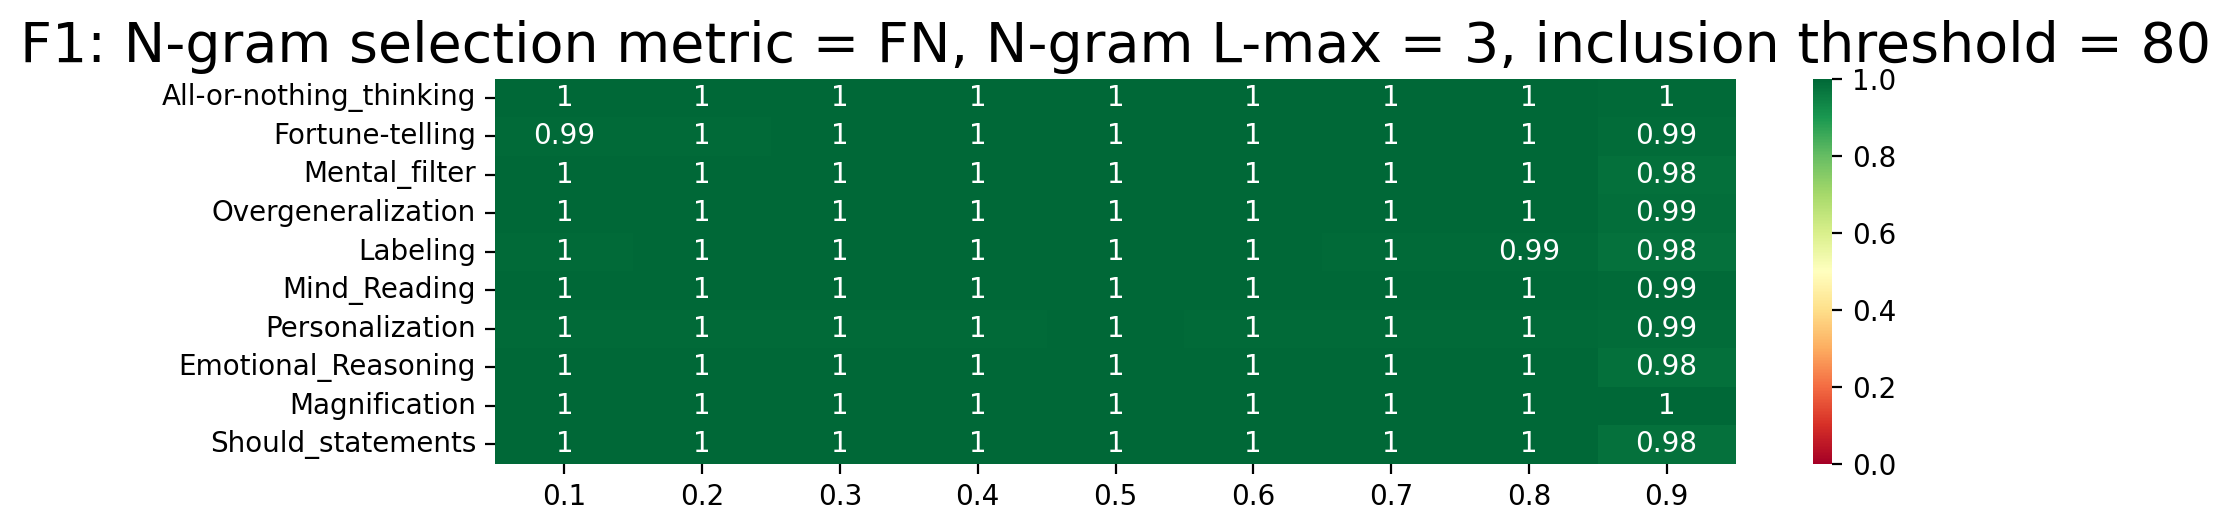

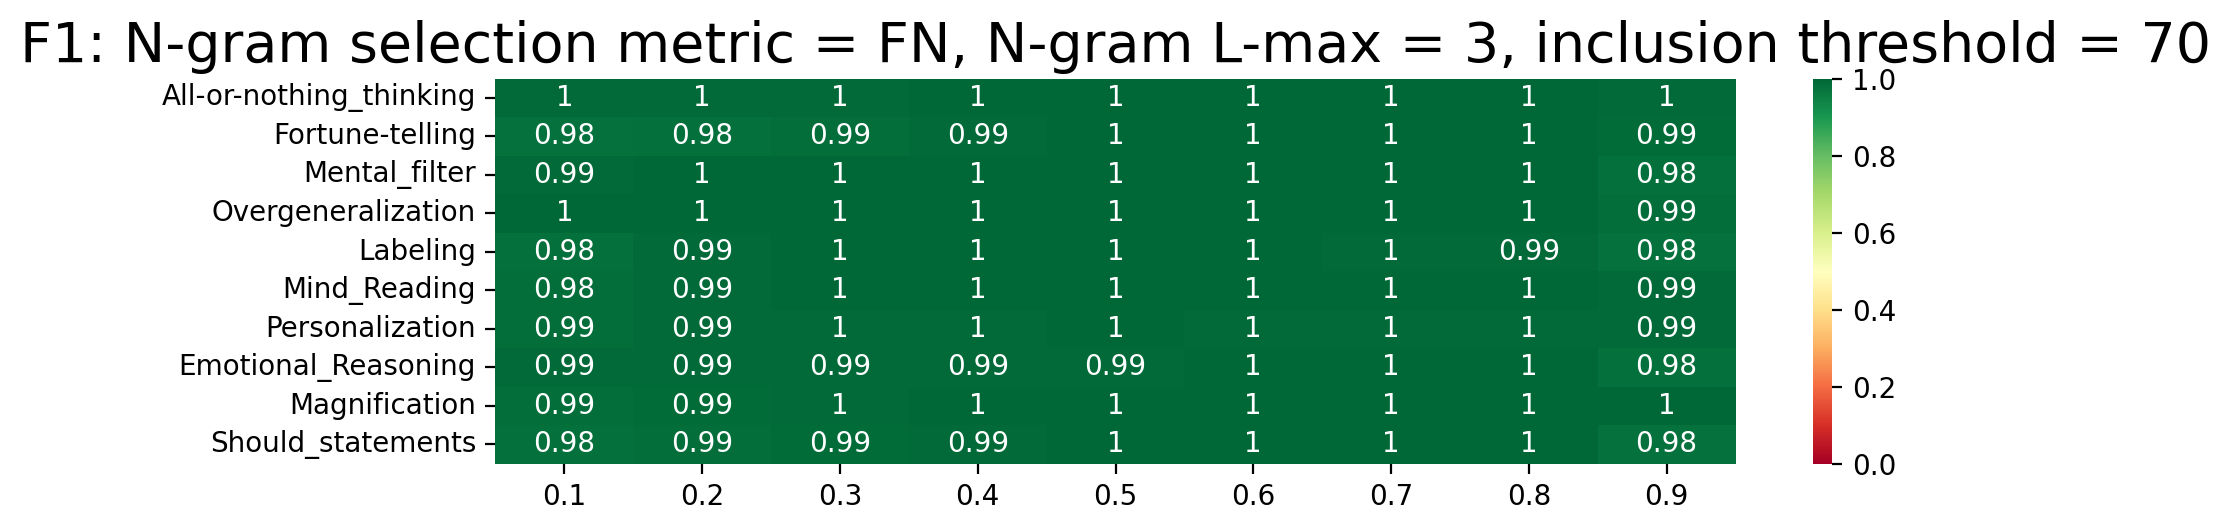

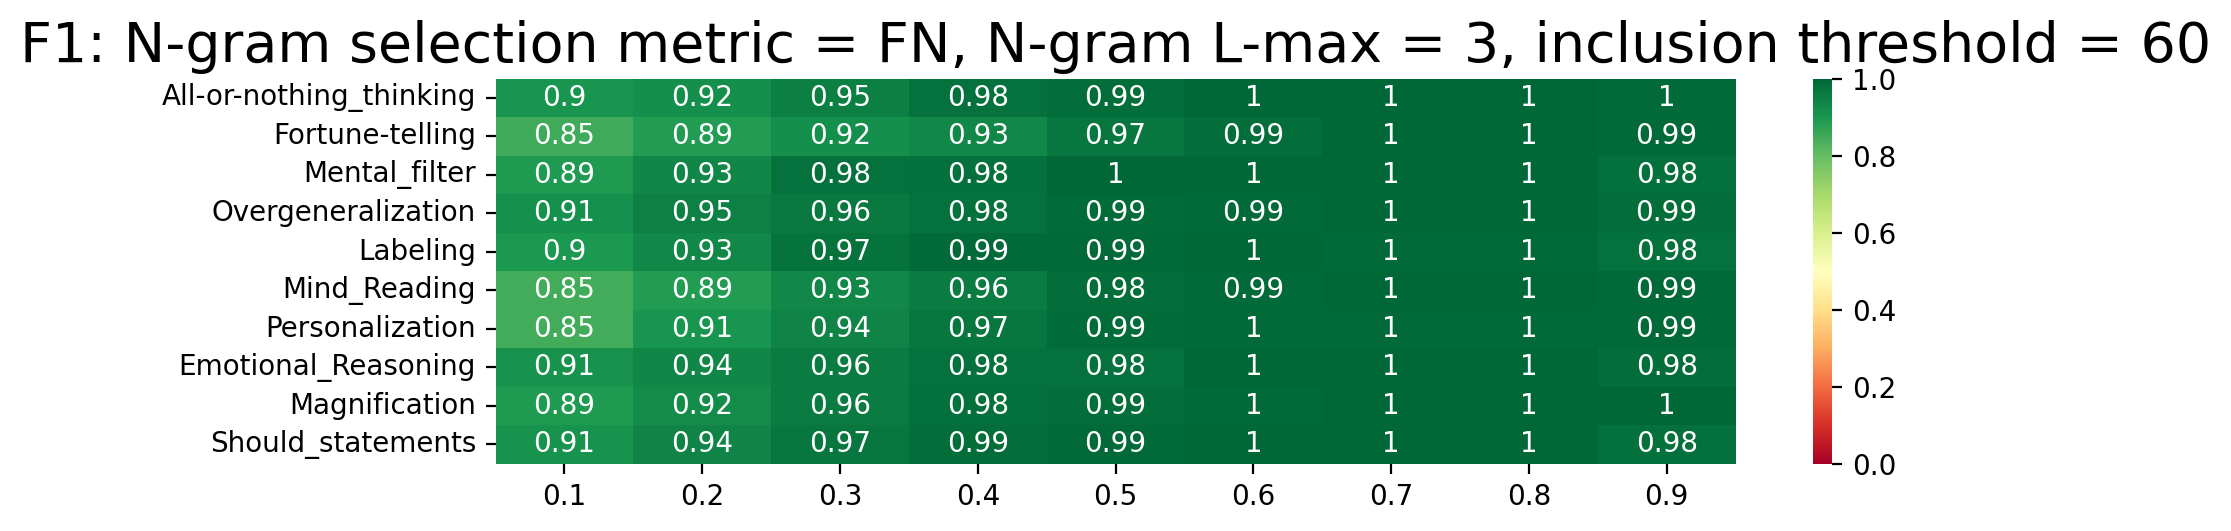

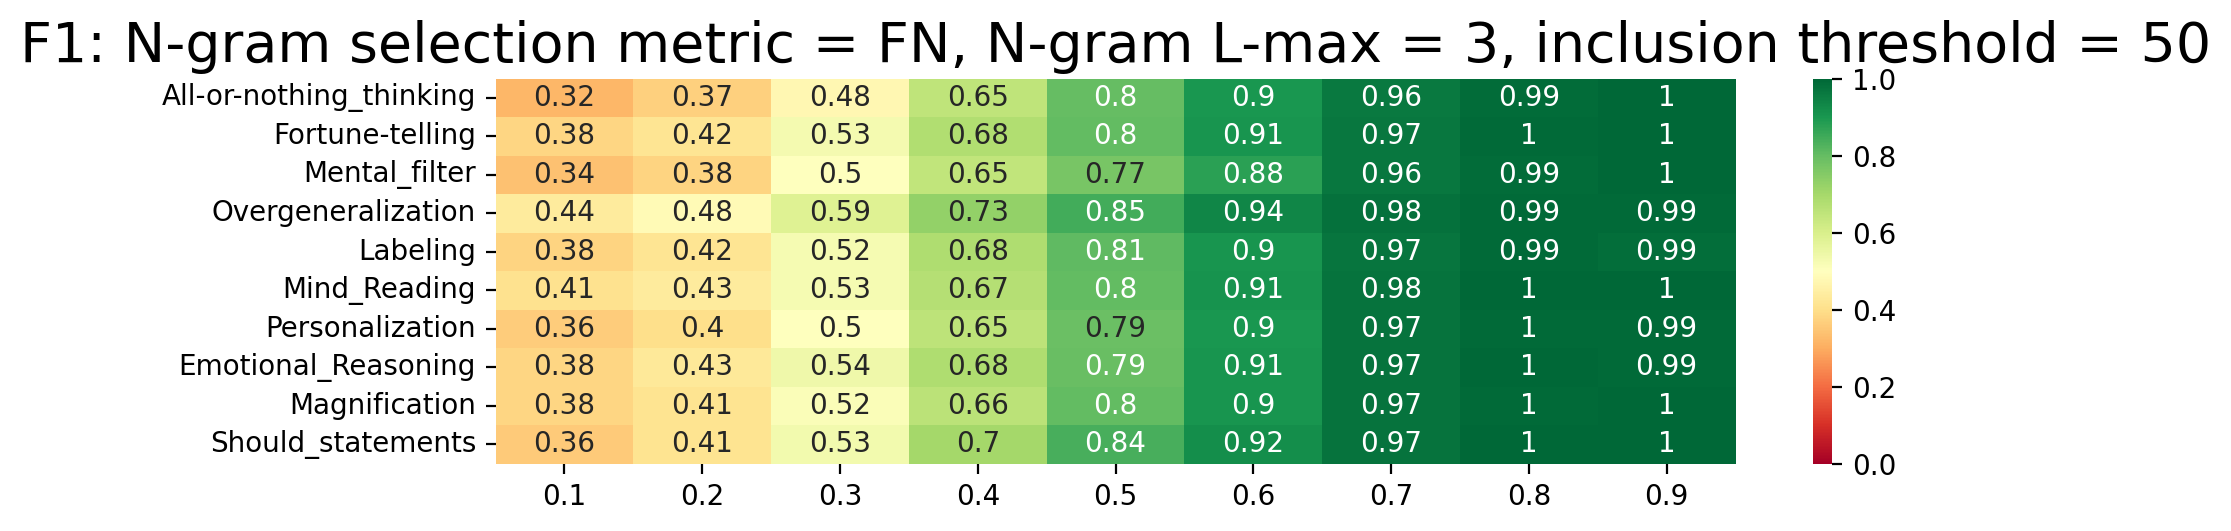

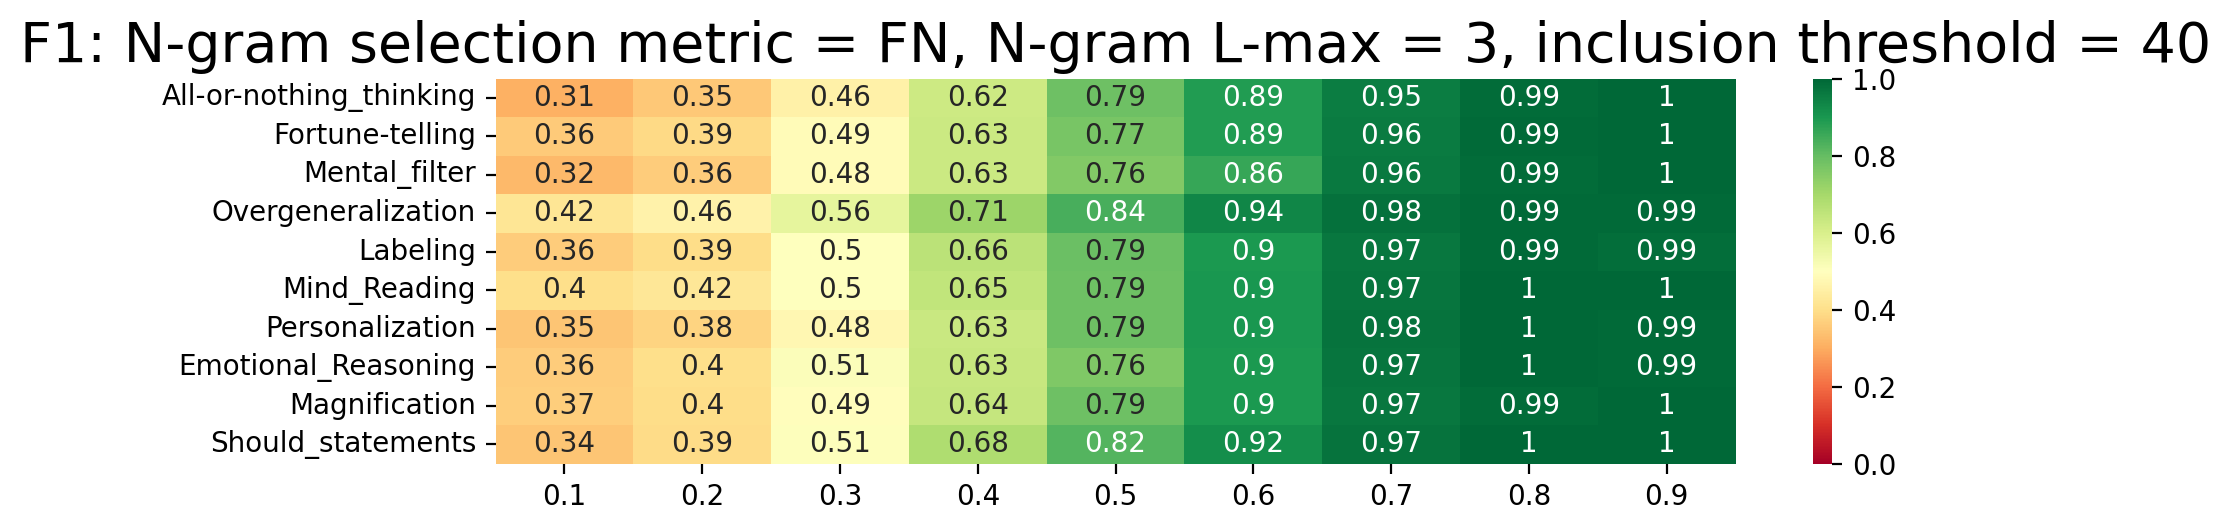

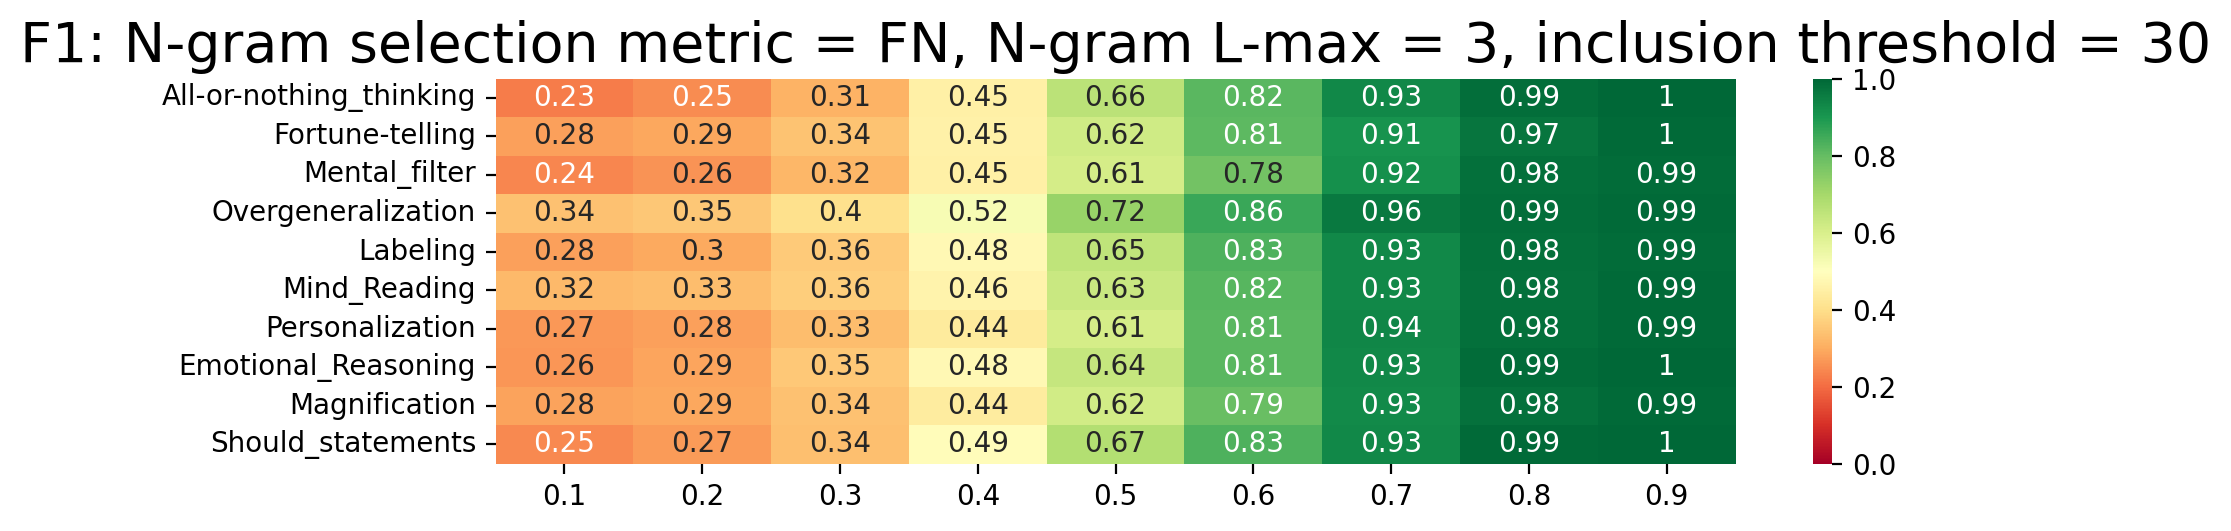

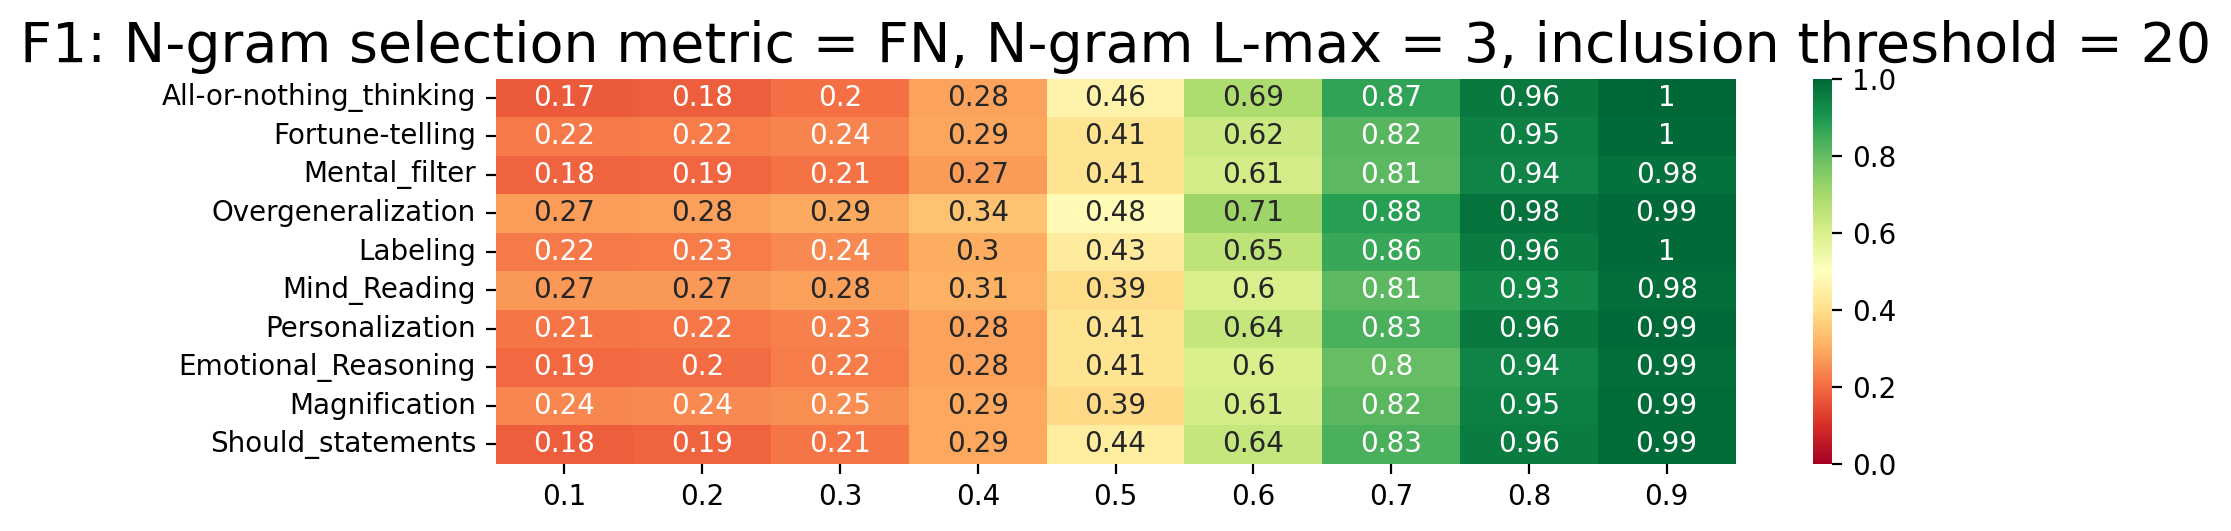

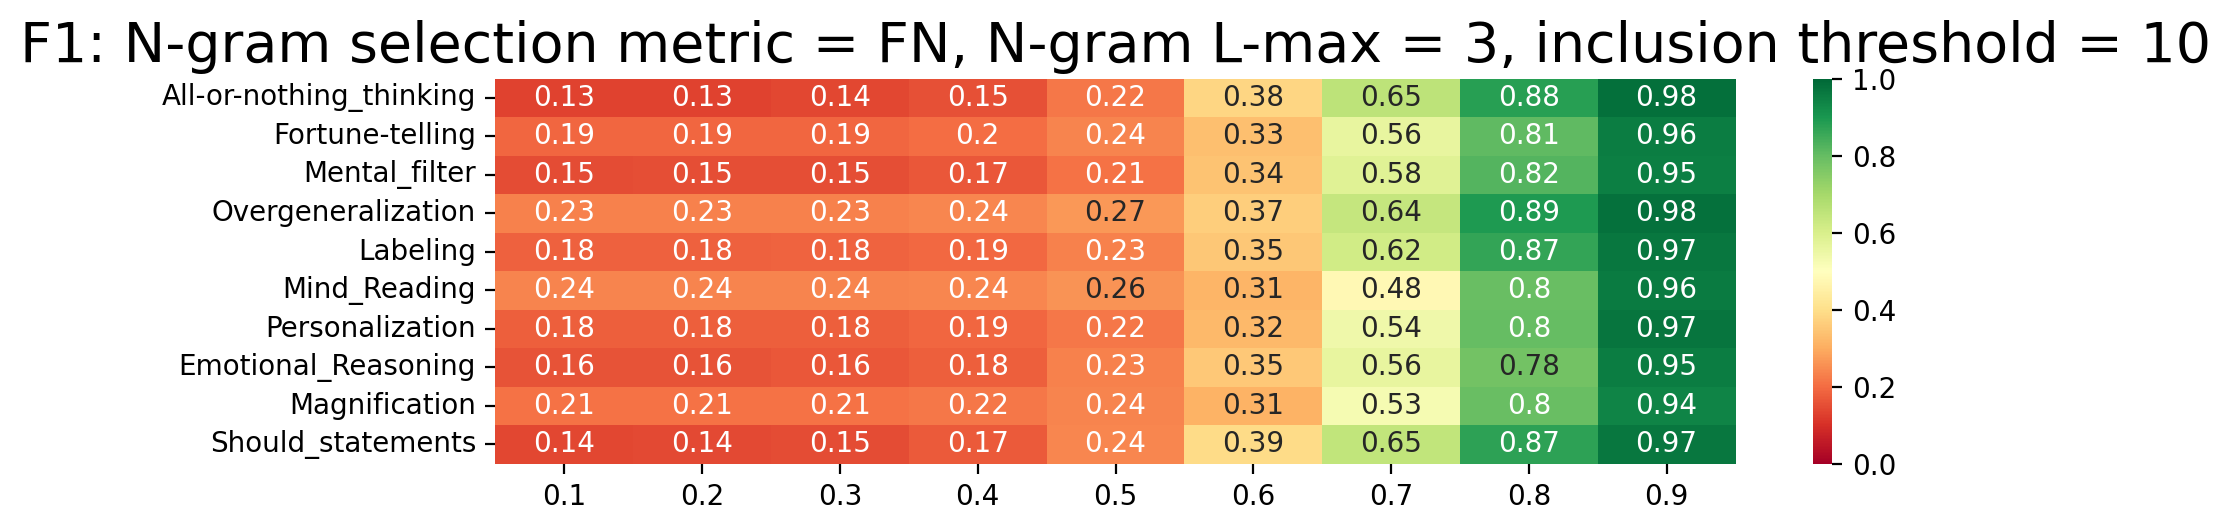

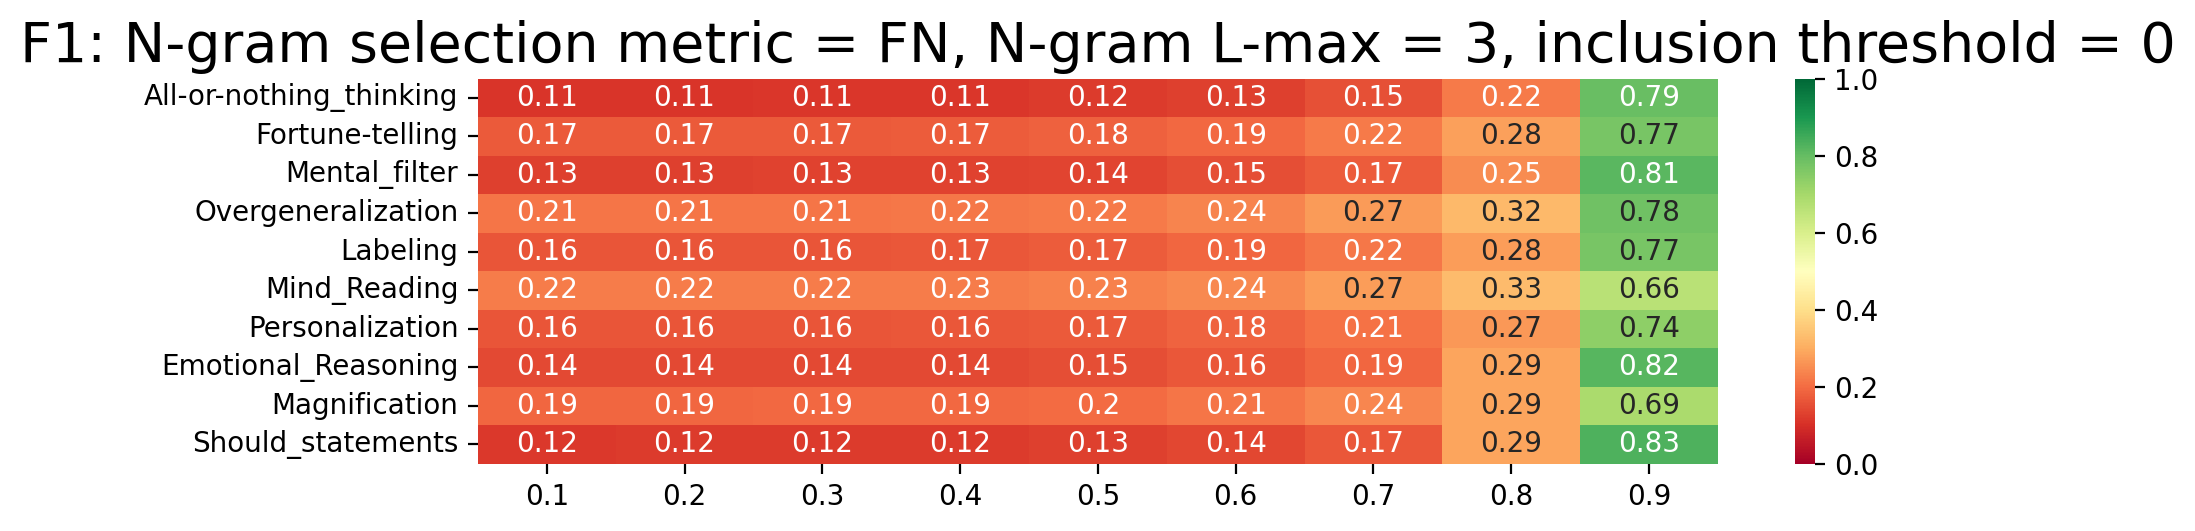

In [11]:
# 1) N-gram selection metric - threshold
for i, ngram_selection_metric in enumerate(ngram_selection_metrics):
    f1s = analyse_dataset(3, df, 'plot_results', ngram_selection_metric, 70)

    matrix_plot(all_metrics, thresholds, f1s, 1.0, 
                title = f'F1: N-gram selection metric = {ngram_selection_metric}, N-gram L-max = 3, inclusion threshold = 70%', 
                vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)


# 2) ngram_max - threshold
for i, ngram_max in enumerate(ngram_max_values):
    f1s = analyse_dataset(ngram_max, df, 'plot_results', ngram_selection_metric = 'FN', ngram_inclusion_threshold = 70)
    matrix_plot(all_metrics, thresholds, f1s, 1.0, 
                title = f'F1: N-gram selection metric = FN, N-gram L-max = {ngram_max}, inclusion threshold = 70%', 
                vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

            
# 3) ngram_inclusion_threshold - threshold
for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):
    f1s = analyse_dataset(3, df, 'plot_results', 'FN', ngram_inclusion_threshold)
    matrix_plot(all_metrics, thresholds, f1s, 1.0, 
                title = f'F1: N-gram selection metric = FN, N-gram L-max = 3, inclusion threshold = {ngram_inclusion_threshold}', 
                vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

In [12]:
# Best model
f1s = analyse_dataset(3, df, 'print_results', 'FN', 70)


N-gram selection metric: FN
N-gram max length: 3
N-gram inclusion threshold: 70
	Threshold: 0.1 (distortion, precision, recall, F1 score, accuracy):
				All-or-nothing_thinking	0.9960474308300395
				Fortune-telling	0.9767441860465117
				Mental_filter	0.993421052631579
				Overgeneralization	0.9963898916967509
				Labeling	0.9805825242718447
				Mind_Reading	0.984974958263773
				Personalization	0.9877149877149877
				Emotional_Reasoning	0.9940828402366864
				Magnification	0.9879032258064516
				Should_statements	0.9818181818181818
	Threshold: 0.2 (distortion, precision, recall, F1 score, accuracy):
				All-or-nothing_thinking	0.9960474308300395
				Fortune-telling	0.9836065573770492
				Mental_filter	0.9966996699669968
				Overgeneralization	0.9963898916967509
				Labeling	0.9926289926289927
				Mind_Reading	0.9932659932659933
				Personalization	0.9925925925925926
				Emotional_Reasoning	0.9940828402366864
				Magnification	0.98989898989899
				Should_statements	0.9854014598540146